In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d birdy654/eeg-brainwave-dataset-feeling-emotions

import zipfile
zip_ref = zipfile.ZipFile('/content/eeg-brainwave-dataset-feeling-emotions.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

 84% 10.0M/11.9M [00:01<00:00, 12.4MB/s]
100% 11.9M/11.9M [00:01<00:00, 8.01MB/s]


In [2]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn import linear_model, svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()

In [4]:
df=pd.read_csv("emotions.csv")

In [5]:
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


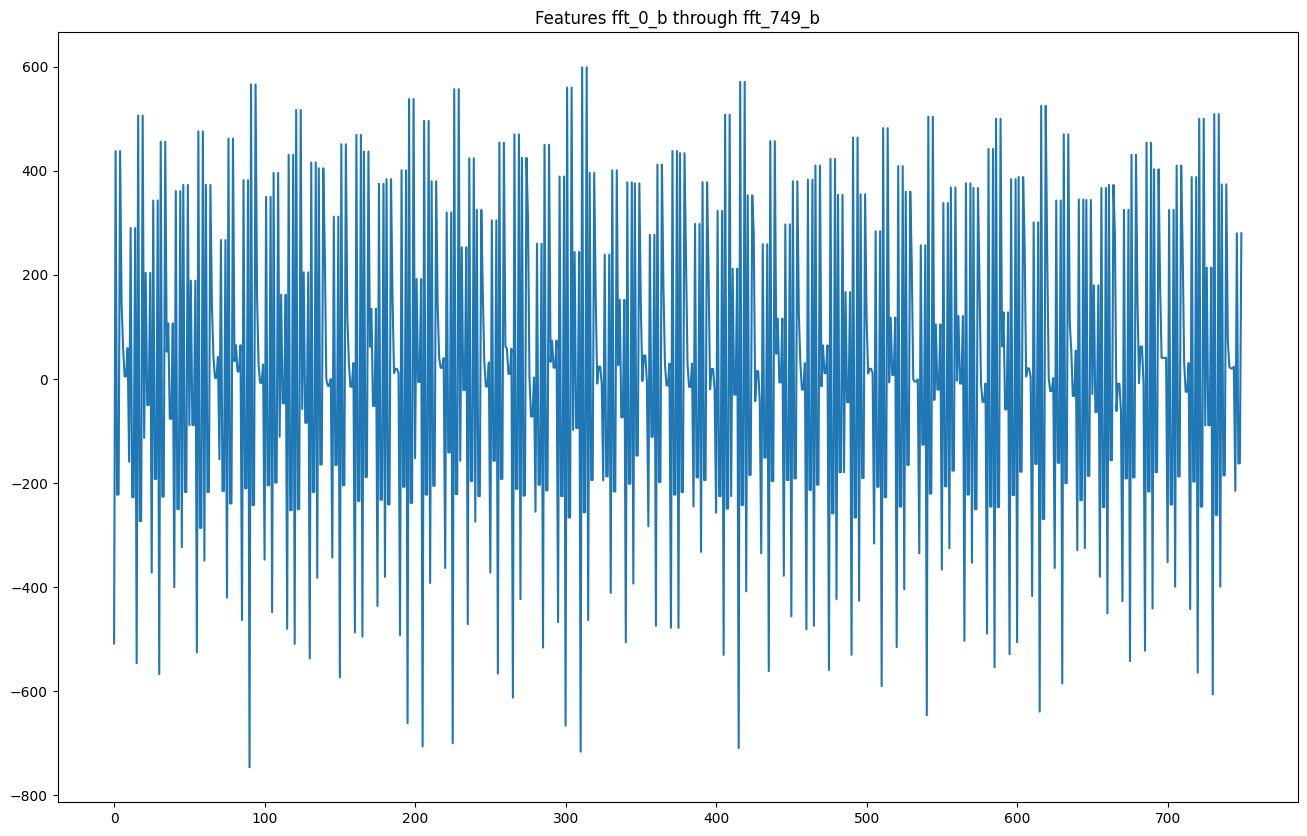

In [6]:
sample = df.loc[0, 'fft_0_b':'fft_749_b']

plt.figure(figsize=(16, 10))
plt.plot(range(len(sample)), sample)
plt.title("Features fft_0_b through fft_749_b")
plt.show()

In [7]:
df.shape

(2132, 2549)

In [8]:
df['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

In [9]:
df.isnull().sum()

# mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
label         0
Length: 2549, dtype: int64

In [10]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
df['label'] = df['label'].replace(label_mapping)

In [11]:
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,0
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,1
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,2
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,2
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,1


In [12]:
x = df.drop('label', axis=1)
y = df['label'].copy()

In [13]:
# Standard Normalisation :- (-1 to 1)
# The standard score of a sample x is calculated as:
# z = (x - u) / s
# where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state = 42)

X_train, X_val, y_train, y_val=train_test_split(X_train, y_train,test_size=0.2, random_state=42)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(1193, 2548)
(1193, 3)
(640, 2548)
(640, 3)
(299, 2548)
(299, 3)


# ML Algorithms

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import xgboost as xgb


In [17]:
label_df = df['label'].copy()
label_df= df.drop('label', axis = 1)

In [18]:
correlations = df.corr(method='pearson')
correlations

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
# mean_0_a,1.000000,0.176578,0.429810,0.582697,0.178432,-0.000665,0.105961,-0.061046,0.135370,0.008472,...,-0.245671,0.204764,0.204764,-0.245671,0.268983,-0.220566,0.196653,0.196653,-0.220566,-0.092295
mean_1_a,0.176578,1.000000,-0.007202,0.571530,0.385041,-0.088608,-0.007586,-0.050463,-0.119391,-0.017197,...,-0.047208,0.002549,0.002549,-0.047208,0.153244,-0.096173,0.069532,0.069532,-0.096173,-0.144903
mean_2_a,0.429810,-0.007202,1.000000,0.081567,-0.095696,0.015122,0.014605,-0.004320,0.055625,-0.003564,...,-0.742275,0.622567,0.622567,-0.742275,0.674195,-0.728296,0.565044,0.565044,-0.728296,0.488417
mean_3_a,0.582697,0.571530,0.081567,1.000000,0.220842,-0.117748,0.124462,-0.175592,-0.001782,0.017110,...,-0.067460,0.048202,0.048202,-0.067460,0.103294,-0.061376,0.051216,0.051216,-0.061376,-0.222676
mean_4_a,0.178432,0.385041,-0.095696,0.220842,1.000000,-0.017196,-0.007570,0.025546,-0.033443,-0.020361,...,0.069458,-0.090163,-0.090163,0.069458,-0.039620,0.056452,-0.016933,-0.016933,0.056452,-0.188521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fft_746_b,-0.220566,-0.096173,-0.728296,-0.061376,0.056452,0.002976,-0.001477,-0.061713,0.005671,-0.005395,...,0.531019,-0.459876,-0.459876,0.531019,-0.938696,1.000000,-0.815108,-0.815108,1.000000,-0.375828
fft_747_b,0.196653,0.069532,0.565044,0.051216,-0.016933,-0.017169,0.003350,0.149472,-0.040408,0.003422,...,-0.355117,0.499272,0.499272,-0.355117,0.834622,-0.815108,1.000000,1.000000,-0.815108,0.286878
fft_748_b,0.196653,0.069532,0.565044,0.051216,-0.016933,-0.017169,0.003350,0.149472,-0.040408,0.003422,...,-0.355117,0.499272,0.499272,-0.355117,0.834622,-0.815108,1.000000,1.000000,-0.815108,0.286878
fft_749_b,-0.220566,-0.096173,-0.728296,-0.061376,0.056452,0.002976,-0.001477,-0.061713,0.005671,-0.005395,...,0.531019,-0.459876,-0.459876,0.531019,-0.938696,1.000000,-0.815108,-0.815108,1.000000,-0.375828


In [19]:
skew = df.skew()
skew

# mean_0_a    3.839961
mean_1_a     -5.400903
mean_2_a     -1.769376
mean_3_a      0.293842
mean_4_a     -3.911369
                ...   
fft_746_b     1.443938
fft_747_b     1.221094
fft_748_b     1.221094
fft_749_b     1.443938
label         0.000000
Length: 2549, dtype: float64

### Logistic Regression Classifier

In [20]:
y_test_lr=np.argmax(y_test,axis=1)
clf_lr = linear_model.LogisticRegression(solver = 'liblinear', C = 75)
clf_lr.fit(X_train, np.argmax(y_train,axis=1))
y_pred_lr = clf_lr.predict(X_test)
acc_lr= accuracy_score(y_test_lr, y_pred_lr)
print('Accuracy of LR:', acc_lr)

Accuracy of LR: 0.9609375


Confusion Matrix:
 [[207   0  13]
 [  0 214   2]
 [  9   1 194]]


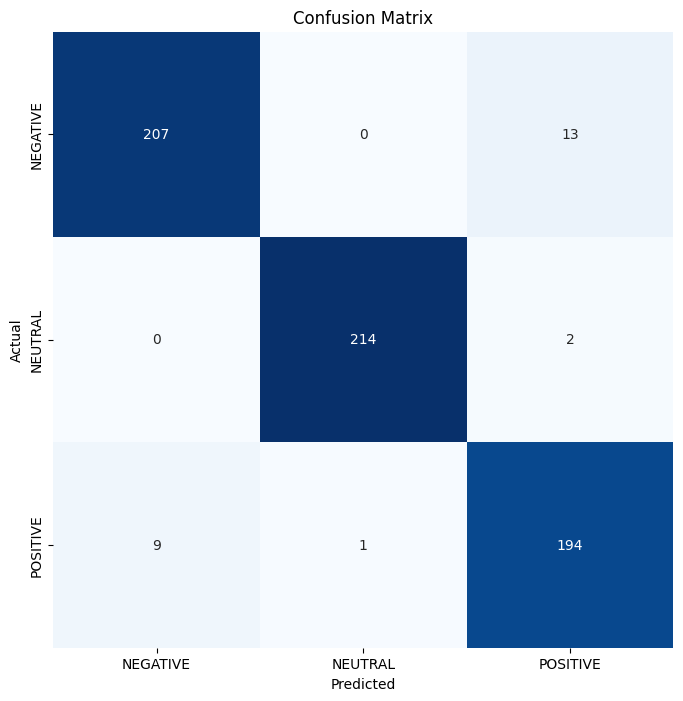

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_lr,y_test_lr)

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [22]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_lr,y_test_lr, target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.94      0.95       220
     NEUTRAL       1.00      0.99      0.99       216
    POSITIVE       0.93      0.95      0.94       204

    accuracy                           0.96       640
   macro avg       0.96      0.96      0.96       640
weighted avg       0.96      0.96      0.96       640



ROC AUC score: 0.970557286625747


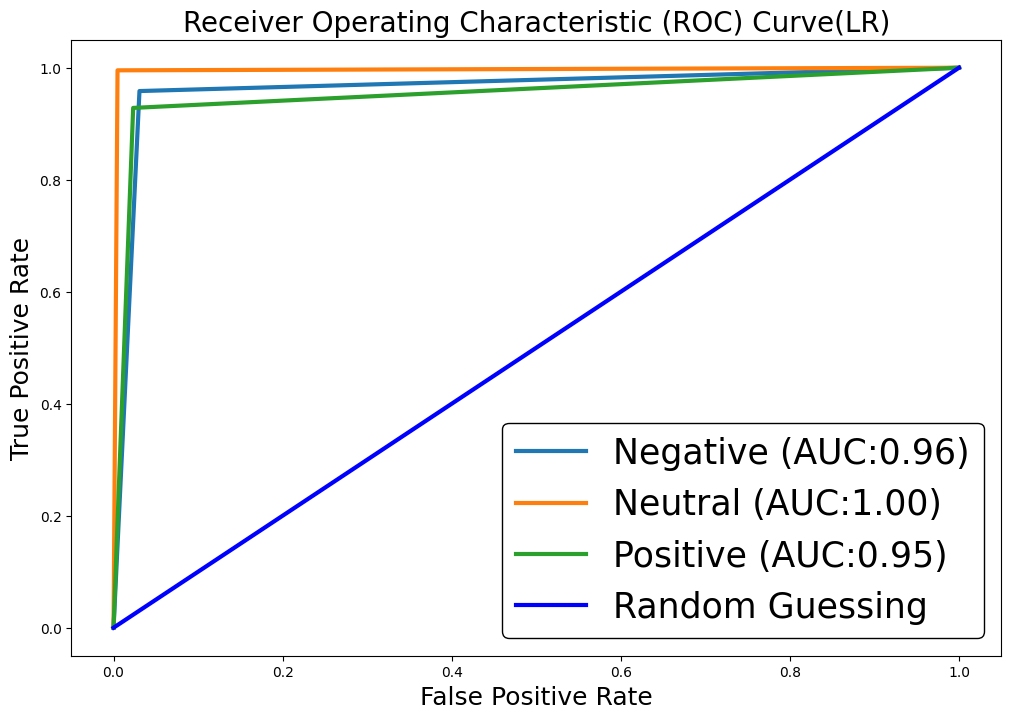

In [23]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(y_test_lr, y_pred_lr))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(LR)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_lr.png', dpi=300, bbox_inches='tight')
plt.show()


### Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB

In [25]:
%%time
clf_gnb = GaussianNB()
clf_gnb.fit(X_train, np.argmax(y_train,axis=1))
y_pred_gnb = clf_gnb.predict(X_test)
acc_nb = accuracy_score(np.argmax(y_test,axis=1), y_pred_gnb)
print('Accuracy:', acc_nb)

Accuracy: 0.63125
CPU times: user 52 ms, sys: 969 µs, total: 53 ms
Wall time: 62.5 ms


Confusion Matrix:
 [[120   0  21]
 [  0 208 112]
 [ 96   7  76]]


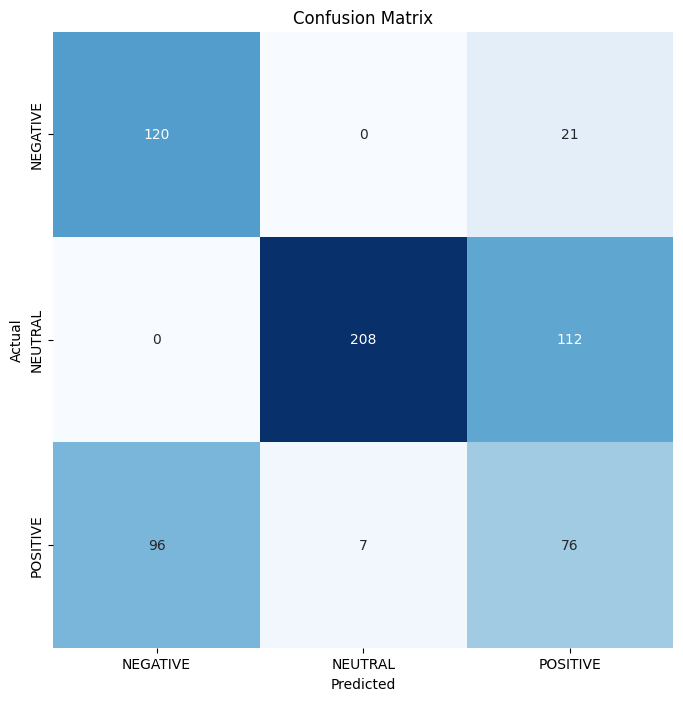

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_gnb,y_test.argmax(axis=1))

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [27]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_gnb,y_test.argmax(axis=1), target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.56      0.85      0.67       141
     NEUTRAL       0.97      0.65      0.78       320
    POSITIVE       0.36      0.42      0.39       179

    accuracy                           0.63       640
   macro avg       0.63      0.64      0.61       640
weighted avg       0.71      0.63      0.65       640



ROC AUC score: 0.7224328246126785


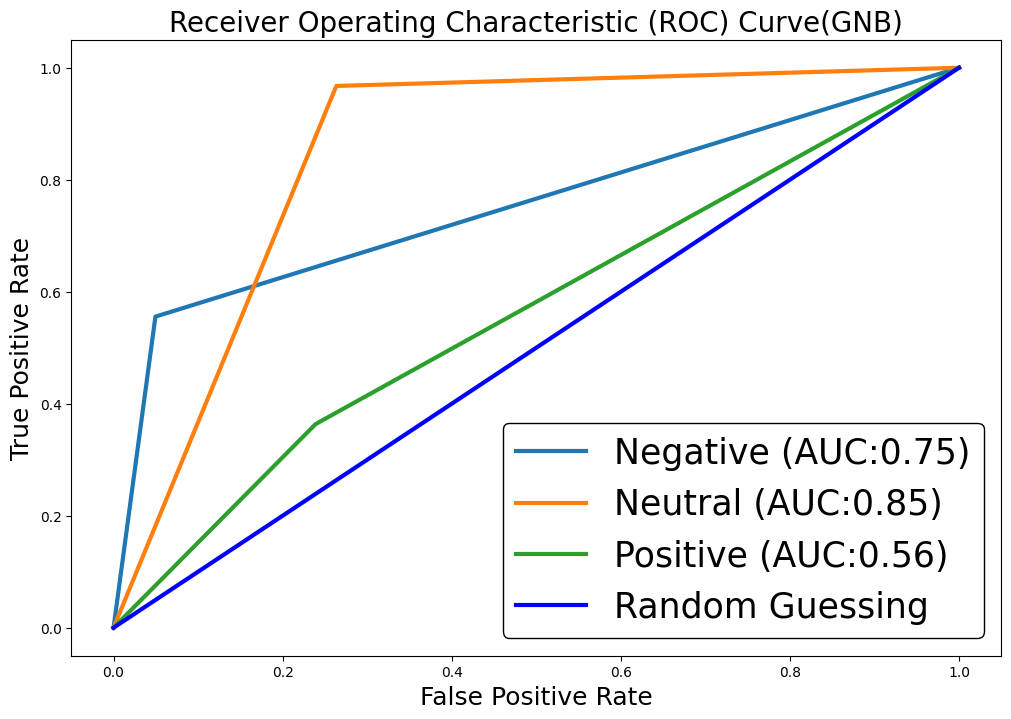

In [28]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(np.argmax(y_test,axis=1), y_pred_gnb))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(GNB)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_gnb.png', dpi=300, bbox_inches='tight')
plt.show()


### Decision Tree

In [29]:
%%time
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, np.argmax(y_train,axis=1))
y_pred_dt = clf_dt.predict(X_test)
acc_dt = accuracy_score(np.argmax(y_test,axis=1), y_pred_dt)
print('Accuracy:', acc_dt)

Accuracy: 0.9578125
CPU times: user 1.49 s, sys: 6.89 ms, total: 1.5 s
Wall time: 1.5 s


Confusion Matrix:
 [[205   0  14]
 [  0 215   2]
 [ 11   0 193]]


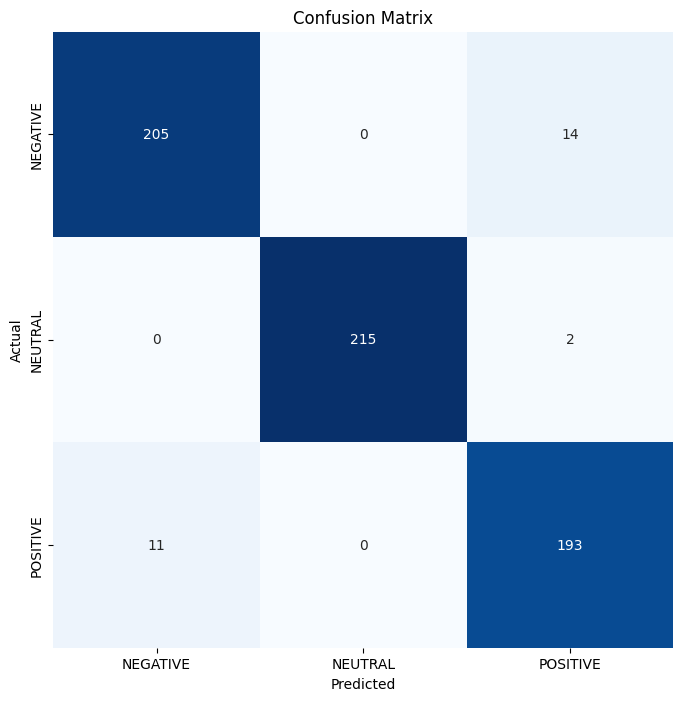

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_dt,y_test.argmax(axis=1))

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [31]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_dt,y_test.argmax(axis=1), target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.95      0.94      0.94       219
     NEUTRAL       1.00      0.99      1.00       217
    POSITIVE       0.92      0.95      0.93       204

    accuracy                           0.96       640
   macro avg       0.96      0.96      0.96       640
weighted avg       0.96      0.96      0.96       640



ROC AUC score: 0.968212043018303


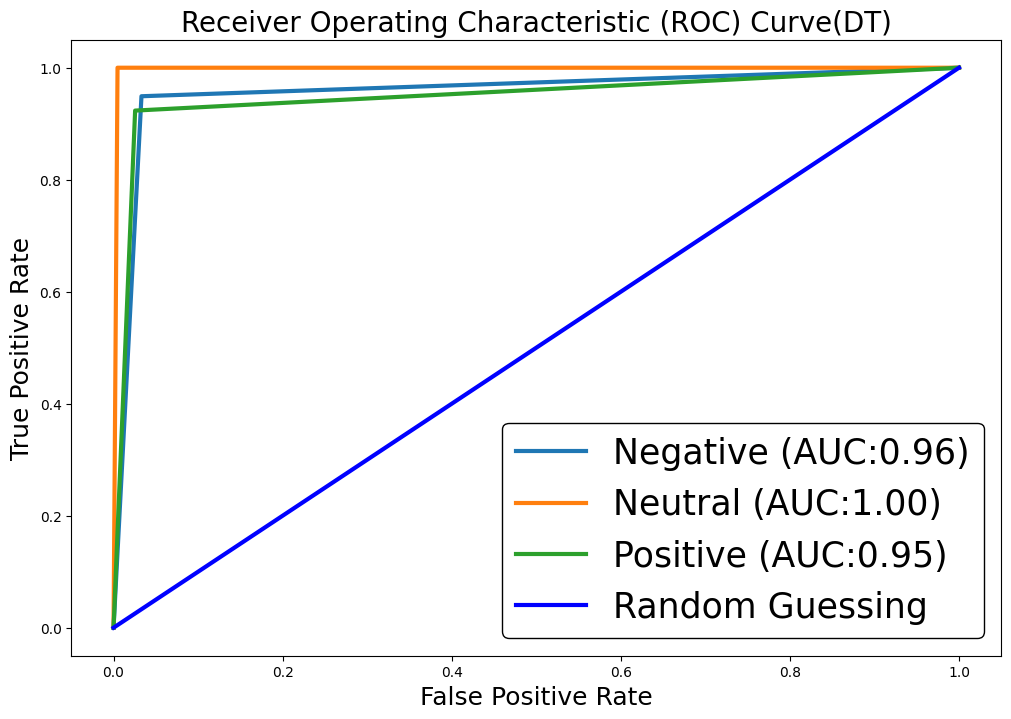

In [32]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(np.argmax(y_test,axis=1), y_pred_dt))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(DT)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_dt.png', dpi=300, bbox_inches='tight')
plt.show()



### Linear Support Vector Machines Classifier (SVM)

In [33]:
%%time
clf_svm = Pipeline(steps=[('scaler',StandardScaler()),
                             ('pl_svm', LinearSVC())])
clf_svm.fit(X_train, np.argmax(y_train,axis=1))
y_pred_svm = clf_svm.predict(X_test)
acc_svm = accuracy_score(np.argmax(y_test,axis=1), y_pred_svm)
print('Accuracy:', acc_svm)

Accuracy: 0.95
CPU times: user 6.29 s, sys: 35.6 ms, total: 6.33 s
Wall time: 6.35 s


Confusion Matrix:
 [[206   0  14]
 [  0 210   3]
 [ 10   5 192]]


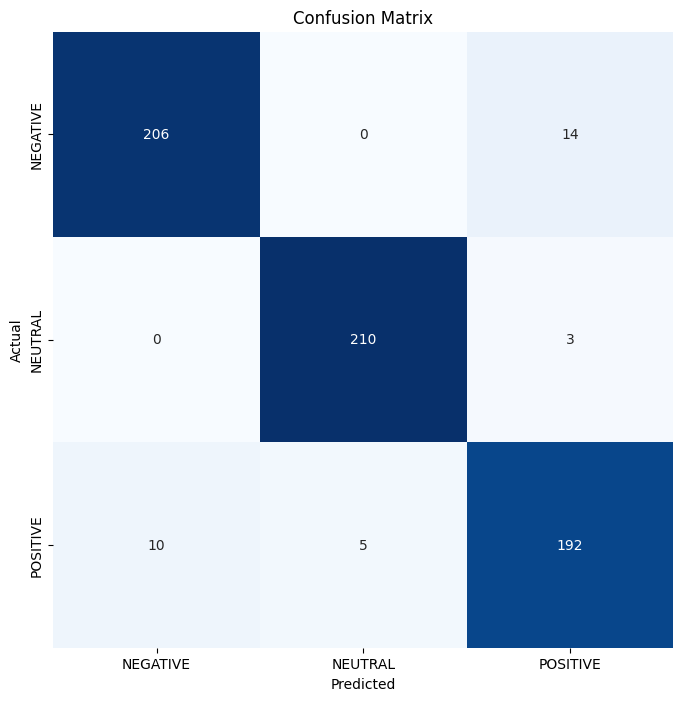

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_svm,y_test.argmax(axis=1))

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [35]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_svm,y_test.argmax(axis=1), target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.95      0.94      0.94       220
     NEUTRAL       0.98      0.99      0.98       213
    POSITIVE       0.92      0.93      0.92       207

    accuracy                           0.95       640
   macro avg       0.95      0.95      0.95       640
weighted avg       0.95      0.95      0.95       640



ROC AUC score: 0.9623712835258128


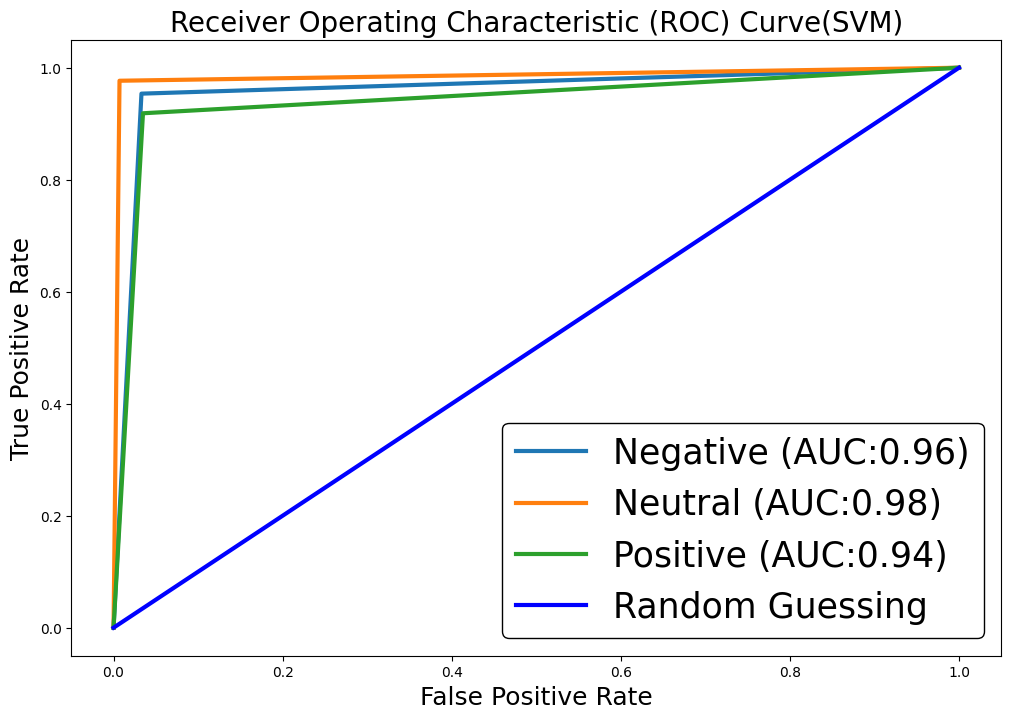

In [36]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(np.argmax(y_test,axis=1), y_pred_svm))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(SVM)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_svm.png', dpi=300, bbox_inches='tight')
plt.show()


### Random Forest

In [37]:
%%time
clf_rf = RandomForestClassifier(n_estimators = 50, random_state = 0)
clf_rf.fit(X_train, np.argmax(y_train,axis=1))
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(np.argmax(y_test,axis=1), y_pred_rf)
print('Accuracy:', acc_rf)

Accuracy: 0.9828125
CPU times: user 1.16 s, sys: 5.08 ms, total: 1.17 s
Wall time: 1.17 s


Confusion Matrix:
 [[213   0   8]
 [  0 215   0]
 [  3   0 201]]


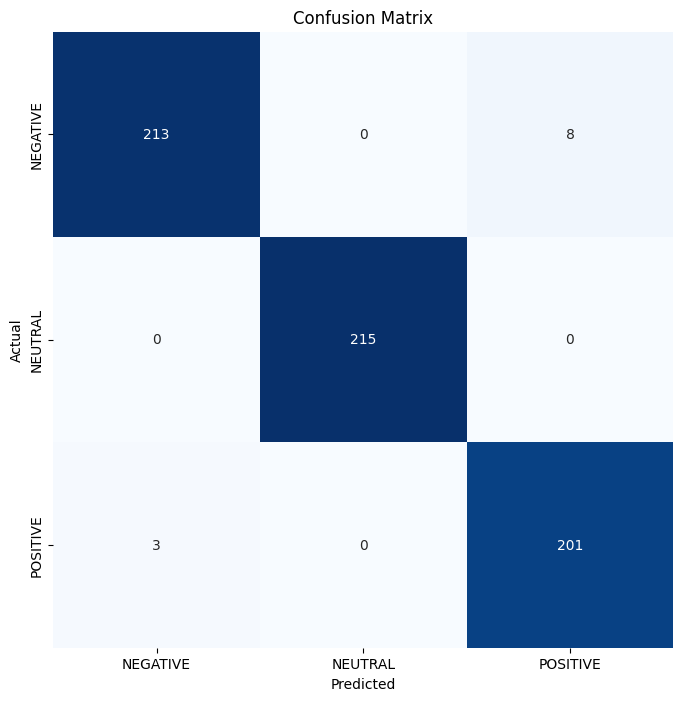

In [38]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_rf,y_test.argmax(axis=1))

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [39]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_rf,y_test.argmax(axis=1), target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.96      0.97       221
     NEUTRAL       1.00      1.00      1.00       215
    POSITIVE       0.96      0.99      0.97       204

    accuracy                           0.98       640
   macro avg       0.98      0.98      0.98       640
weighted avg       0.98      0.98      0.98       640



ROC AUC score: 0.9870008529627565


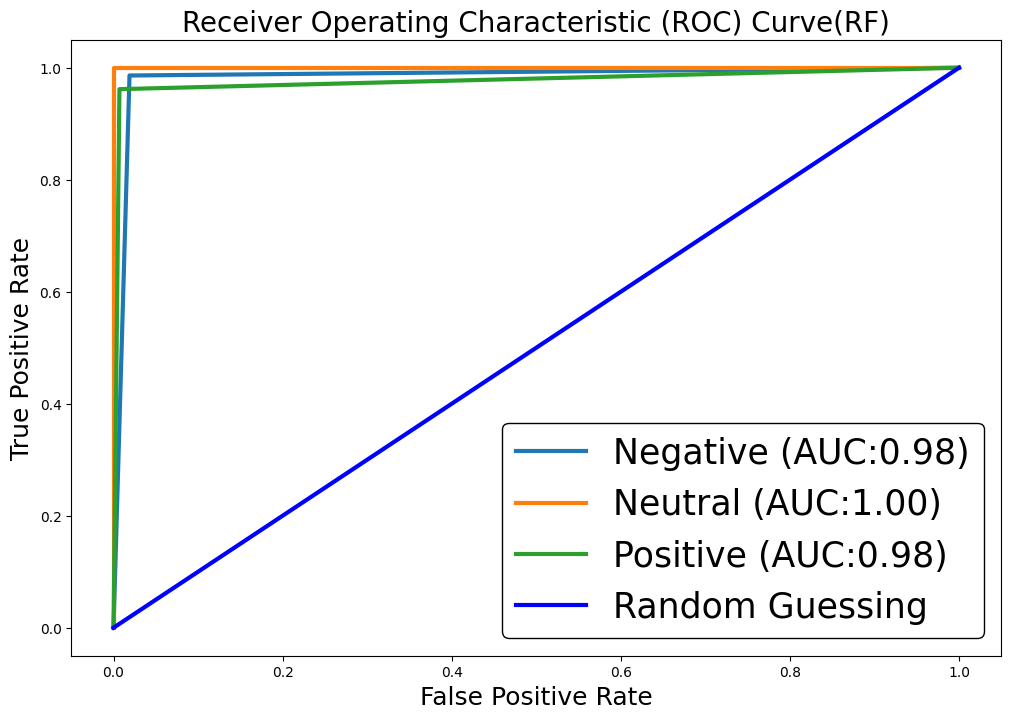

In [40]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(np.argmax(y_test,axis=1), y_pred_rf))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(RF)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_rf.png', dpi=300, bbox_inches='tight')
plt.show()


### AdaBoost

In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [42]:
%%time
base_estimator = DecisionTreeClassifier(max_depth=1)
clf_ab = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100)
clf_ab.fit(X_train, np.argmax(y_train,axis=1))
y_pred_ab = clf_ab.predict(X_test)
acc_ab = accuracy_score(np.argmax(y_test,axis=1), y_pred_ab)
print('Accuracy:', acc_ab)

Accuracy: 0.90625
CPU times: user 32.5 s, sys: 40.1 ms, total: 32.6 s
Wall time: 32.5 s


Confusion Matrix:
 [[206   0  40]
 [  0 206   1]
 [ 10   9 168]]


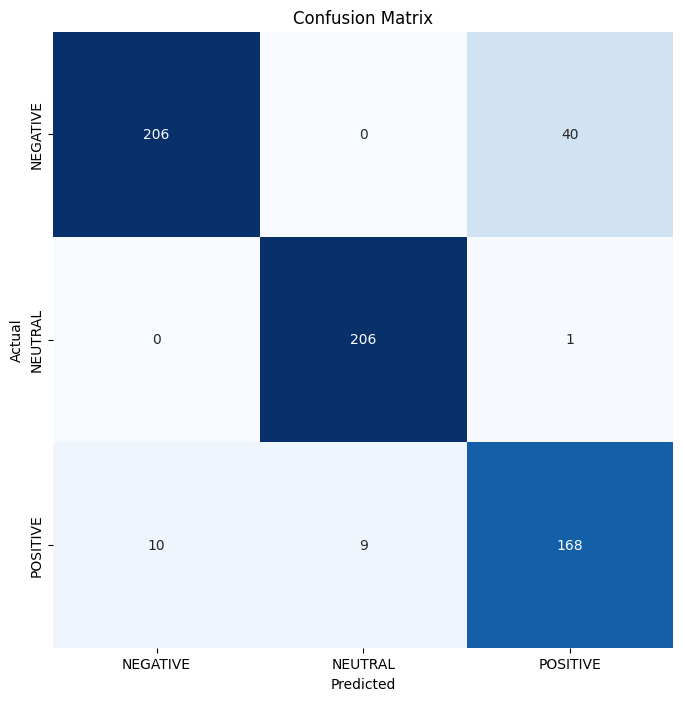

In [43]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_ab,y_test.argmax(axis=1))

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [44]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_ab,y_test.argmax(axis=1), target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.95      0.84      0.89       246
     NEUTRAL       0.96      1.00      0.98       207
    POSITIVE       0.80      0.90      0.85       187

    accuracy                           0.91       640
   macro avg       0.91      0.91      0.91       640
weighted avg       0.91      0.91      0.91       640



ROC AUC score: 0.9291491498805805


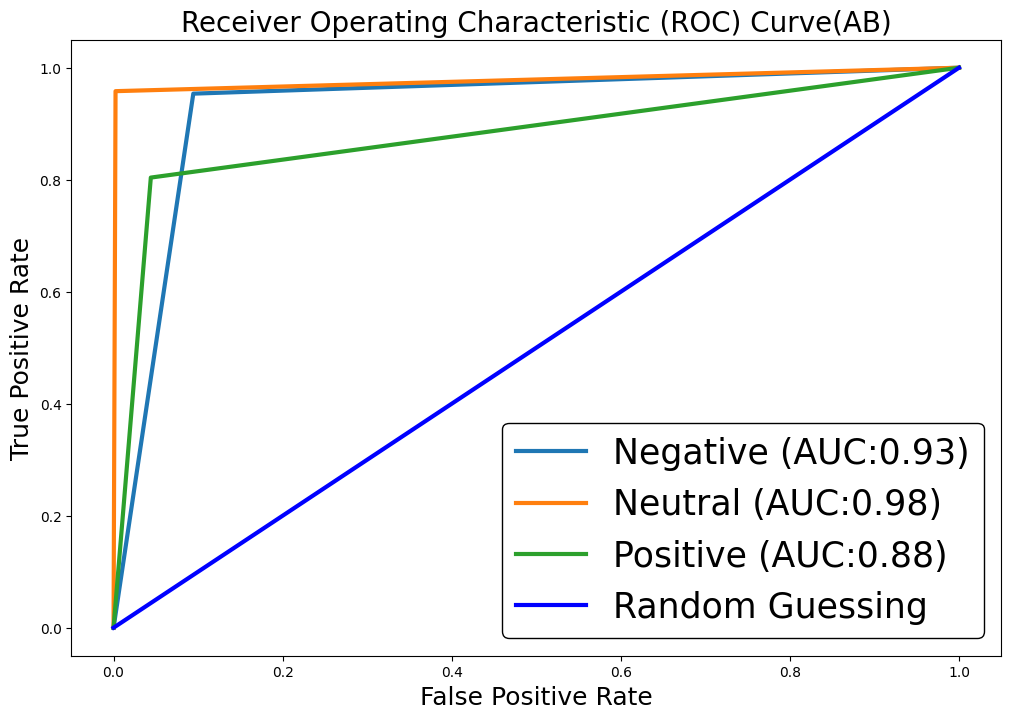

In [45]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(np.argmax(y_test,axis=1), y_pred_ab))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(AB)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_ab.png', dpi=300, bbox_inches='tight')
plt.show()


### XGBoost

In [46]:
%%time
clf_xgb =  Pipeline(steps=
                  [('xgboost', xgb.XGBClassifier(objective='multi:softmax', num_class=3))])
eval_set = [(X_train, np.argmax(y_train, axis=1)), (X_test, np.argmax(y_test, axis=1))]
clf_xgb.fit(X_train, np.argmax(y_train, axis=1), xgboost__eval_metric=["merror", "mlogloss"], xgboost__eval_set=eval_set, xgboost__early_stopping_rounds=8)

y_pred_xgb = clf_xgb.predict(X_test)
acc_xgb = accuracy_score(np.argmax(y_test,axis=1), y_pred_xgb)
print('Accuracy:', acc_xgb)


[0]	validation_0-merror:0.00503	validation_0-mlogloss:0.71532	validation_1-merror:0.04219	validation_1-mlogloss:0.73719
[1]	validation_0-merror:0.00084	validation_0-mlogloss:0.49993	validation_1-merror:0.03750	validation_1-mlogloss:0.53545
[2]	validation_0-merror:0.00084	validation_0-mlogloss:0.36064	validation_1-merror:0.03438	validation_1-mlogloss:0.40658
[3]	validation_0-merror:0.00000	validation_0-mlogloss:0.26120	validation_1-merror:0.03281	validation_1-mlogloss:0.31295
[4]	validation_0-merror:0.00000	validation_0-mlogloss:0.19169	validation_1-merror:0.03281	validation_1-mlogloss:0.24813
[5]	validation_0-merror:0.00000	validation_0-mlogloss:0.14196	validation_1-merror:0.02969	validation_1-mlogloss:0.19787
[6]	validation_0-merror:0.00000	validation_0-mlogloss:0.10607	validation_1-merror:0.02656	validation_1-mlogloss:0.15954
[7]	validation_0-merror:0.00000	validation_0-mlogloss:0.07977	validation_1-merror:0.02500	validation_1-mlogloss:0.13132
[8]	validation_0-merror:0.00000	validati

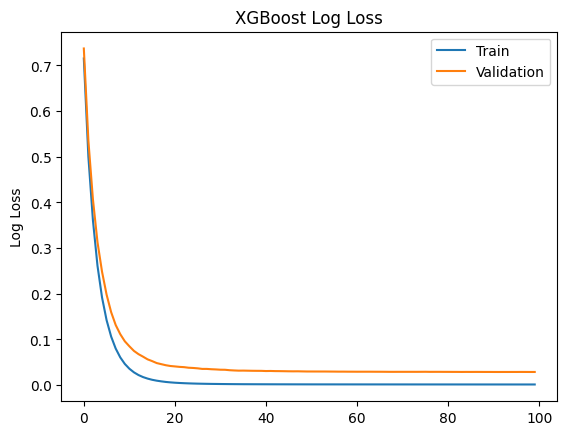

In [47]:
# Plot training and validation loss
results = clf_xgb.named_steps['xgboost'].evals_result()
train_error = results['validation_0']['mlogloss']
val_error = results['validation_1']['mlogloss']
epochs = len(train_error)
x_axis = range(0, epochs)
plt.plot(x_axis, train_error, label='Train')
plt.plot(x_axis, val_error, label='Validation')
plt.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()


Confusion Matrix:
 [[215   0   3]
 [  0 215   1]
 [  1   0 205]]


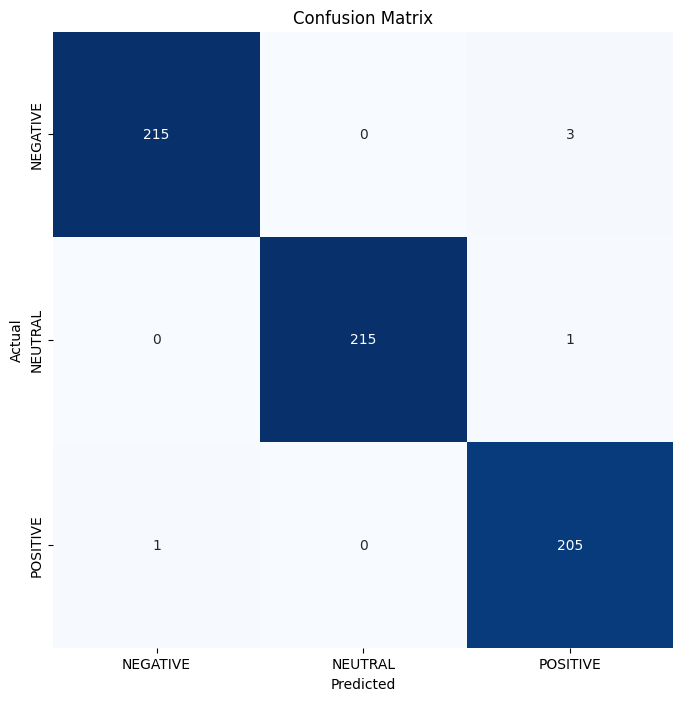

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_xgb,y_test.argmax(axis=1))

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [49]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_xgb,y_test.argmax(axis=1), target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       1.00      0.99      0.99       218
     NEUTRAL       1.00      1.00      1.00       216
    POSITIVE       0.98      1.00      0.99       206

    accuracy                           0.99       640
   macro avg       0.99      0.99      0.99       640
weighted avg       0.99      0.99      0.99       640



ROC AUC score: 0.9940805026500127


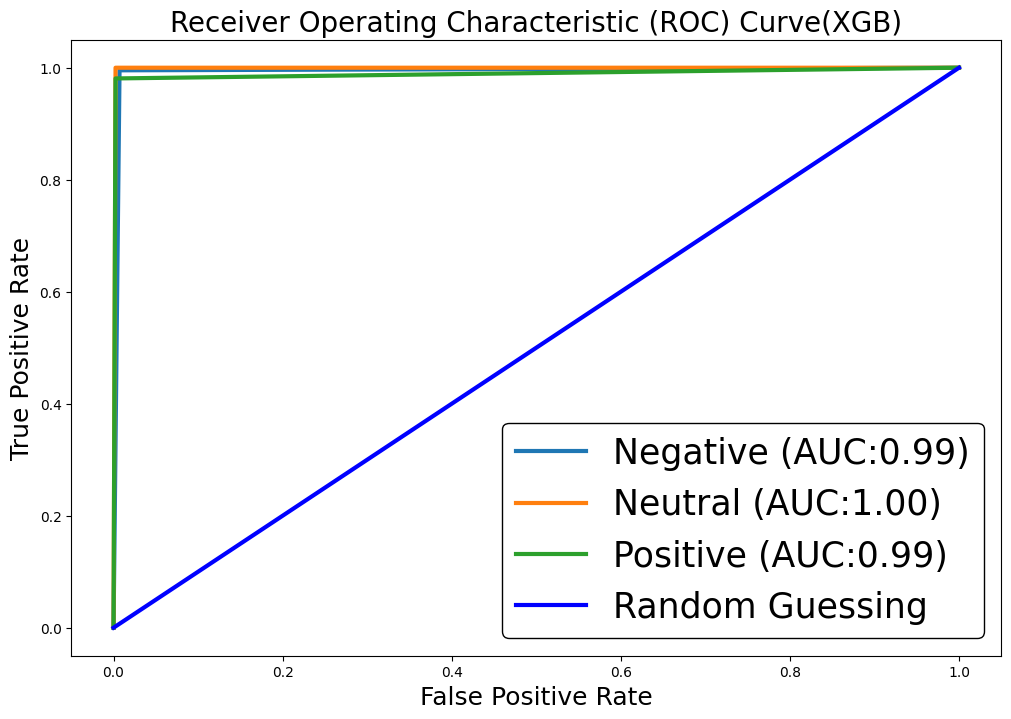

In [50]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(np.argmax(y_test,axis=1), y_pred_xgb))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(XGB)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_xgb.png', dpi=300, bbox_inches='tight')
plt.show()


# Deep Learning 

In [51]:
import warnings
import itertools    
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

### ANN

In [52]:
%%time
clf_ann = Pipeline(steps=[('scaler',StandardScaler()),
                             ('mlp_ann', MLPClassifier(hidden_layer_sizes=(1275, 637)))])
clf_ann.fit(X_train, np.argmax(y_train,axis=1))
y_pred_ann = clf_ann.predict(X_test)
acc_ann = accuracy_score(np.argmax(y_test,axis=1), y_pred_ann)
print('Accuracy:', acc_ann)

Accuracy: 0.9765625
CPU times: user 44.9 s, sys: 15.6 s, total: 1min
Wall time: 34.2 s


Confusion Matrix:
 [[212   0   9]
 [  0 213   0]
 [  4   2 200]]


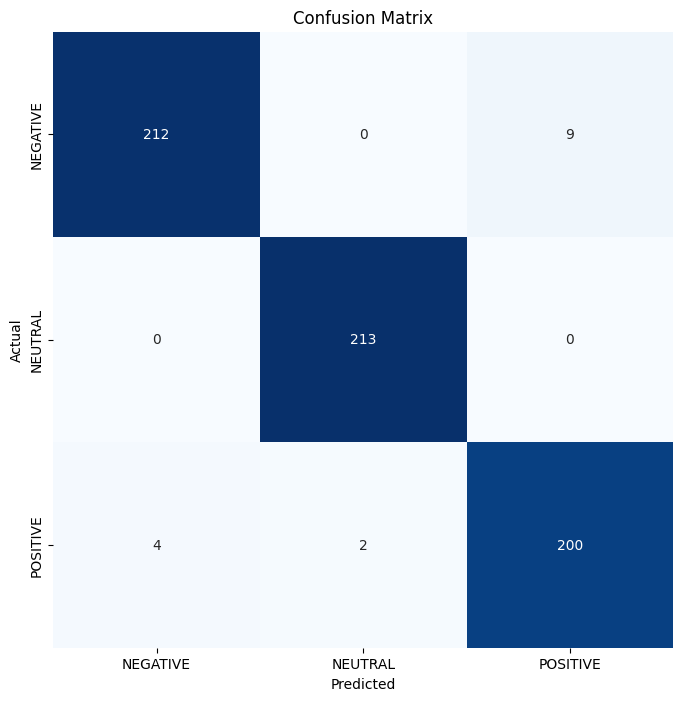

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_ann,y_test.argmax(axis=1))

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [54]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_ann,y_test.argmax(axis=1), target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.96      0.97       221
     NEUTRAL       0.99      1.00      1.00       213
    POSITIVE       0.96      0.97      0.96       206

    accuracy                           0.98       640
   macro avg       0.98      0.98      0.98       640
weighted avg       0.98      0.98      0.98       640



ROC AUC score: 0.9823282376932857


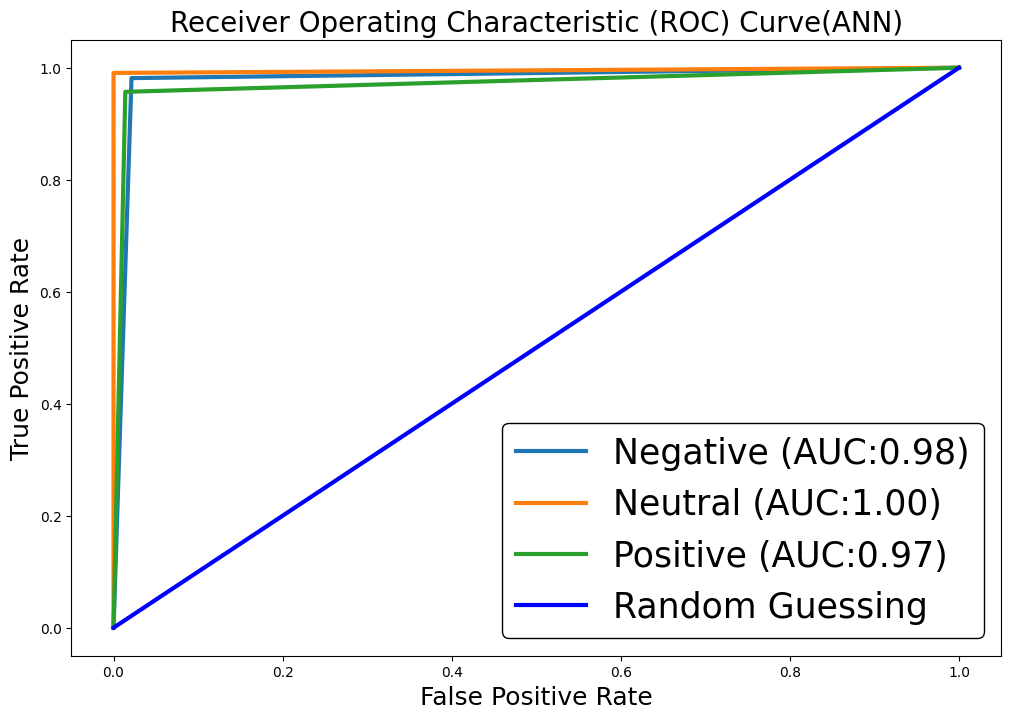

In [55]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(np.argmax(y_test,axis=1), y_pred_ann))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(ANN)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_ann.png', dpi=300, bbox_inches='tight')
plt.show()


### DNN

In [56]:
i_dnn = Input(shape=(2548, ))

x_dnn = Dense(2548, activation='relu')(i_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.25)(x_dnn)

x_dnn = Dense(3822, activation='relu')(x_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.27)(x_dnn)

x_dnn = Dense(5096, activation='relu')(x_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.3)(x_dnn)

x_dnn = Dense(3822, activation='relu')(x_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.27)(x_dnn)

x_dnn = Dense(2548, activation='relu')(x_dnn)
x_dnn = BatchNormalization()(x_dnn)
x_dnn = Dropout(0.25)(x_dnn)

y_dnn = Dense(3, activation='softmax')(x_dnn)

dnn_model = Model(i_dnn, y_dnn)

dnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2548)]            0         
                                                                 
 dense (Dense)               (None, 2548)              6494852   
                                                                 
 batch_normalization (BatchN  (None, 2548)             10192     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 2548)              0         
                                                                 
 dense_1 (Dense)             (None, 3822)              9742278   
                                                                 
 batch_normalization_1 (Batc  (None, 3822)             15288     
 hNormalization)                                             

In [57]:
adam = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_dnn_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
                                    
dnn_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
dnn_h = dnn_model.fit(X_train, y_train,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   epochs=500,
                   callbacks=[es, mc, lr_schedule])

Epoch 1/500
37/38 [============================>.] - ETA: 0s - loss: 1.6394 - accuracy: 0.8345
Epoch 1: val_accuracy improved from -inf to 0.37458, saving model to ./best_dnn_model.h5
38/38 [==============================] - 13s 124ms/step - loss: 1.6416 - accuracy: 0.8332 - val_loss: 109.5506 - val_accuracy: 0.3746 - lr: 0.0010
Epoch 2/500
37/38 [============================>.] - ETA: 0s - loss: 0.3243 - accuracy: 0.8868
Epoch 2: val_accuracy improved from 0.37458 to 0.60201, saving model to ./best_dnn_model.h5
38/38 [==============================] - 4s 114ms/step - loss: 0.3227 - accuracy: 0.8877 - val_loss: 4.6040 - val_accuracy: 0.6020 - lr: 9.0484e-04
Epoch 3/500
37/38 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.9003
Epoch 3: val_accuracy improved from 0.60201 to 0.93311, saving model to ./best_dnn_model.h5
38/38 [==============================] - 4s 109ms/step - loss: 0.2971 - accuracy: 0.9011 - val_loss: 0.4873 - val_accuracy: 0.9331 - lr: 8.1873e-04

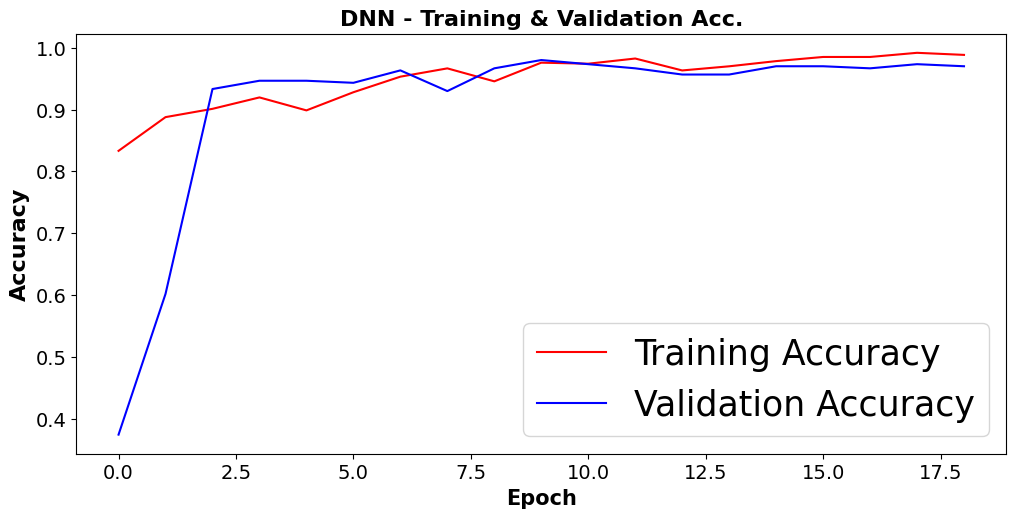

In [58]:
acc_dnn = dnn_h.history['accuracy']
val_acc_dnn = dnn_h.history['val_accuracy']
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc_dnn, label='Training Accuracy', color='r')
plt.plot(val_acc_dnn, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=25)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('DNN - Training & Validation Acc.', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.savefig('t&v_acc_dnn.png', dpi=300, bbox_inches='tight')
plt.show()

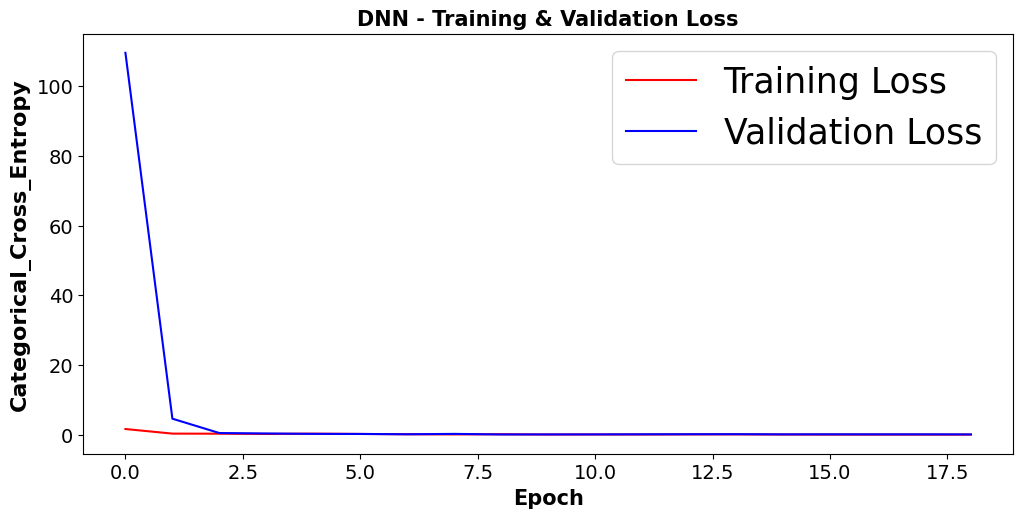

In [59]:
loss_dnn = dnn_h.history['loss']
val_loss_dnn = dnn_h.history['val_loss']
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 2)
plt.plot(loss_dnn, label='Training Loss', color='r')
plt.plot(val_loss_dnn, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=25)
plt.ylabel('Categorical_Cross_Entropy', fontsize=16, weight='bold')
plt.title('DNN - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.savefig('t&v_loss_dnn.png', dpi=300, bbox_inches='tight')
plt.show()

In [60]:
dnn_best = load_model('./best_dnn_model.h5')
dnn_acc = dnn_best.evaluate(X_test, y_test, verbose=0)[1]
print("Test Acc. DNN: {:.3f}%".format(dnn_acc * 100))

Test Acc. DNN: 96.250%


In [61]:
y_pred_dnn = np.array(list(map(lambda x: np.argmax(x), dnn_best.predict(X_test))))
y_test_dnn = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_test_dnn, y_pred_dnn)
print(classification_report(y_test_dnn, y_pred_dnn))

20/20 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       216
           1       0.99      0.99      0.99       215
           2       0.98      0.90      0.94       209

    accuracy                           0.96       640
   macro avg       0.96      0.96      0.96       640
weighted avg       0.96      0.96      0.96       640



Normalized confusion matrix


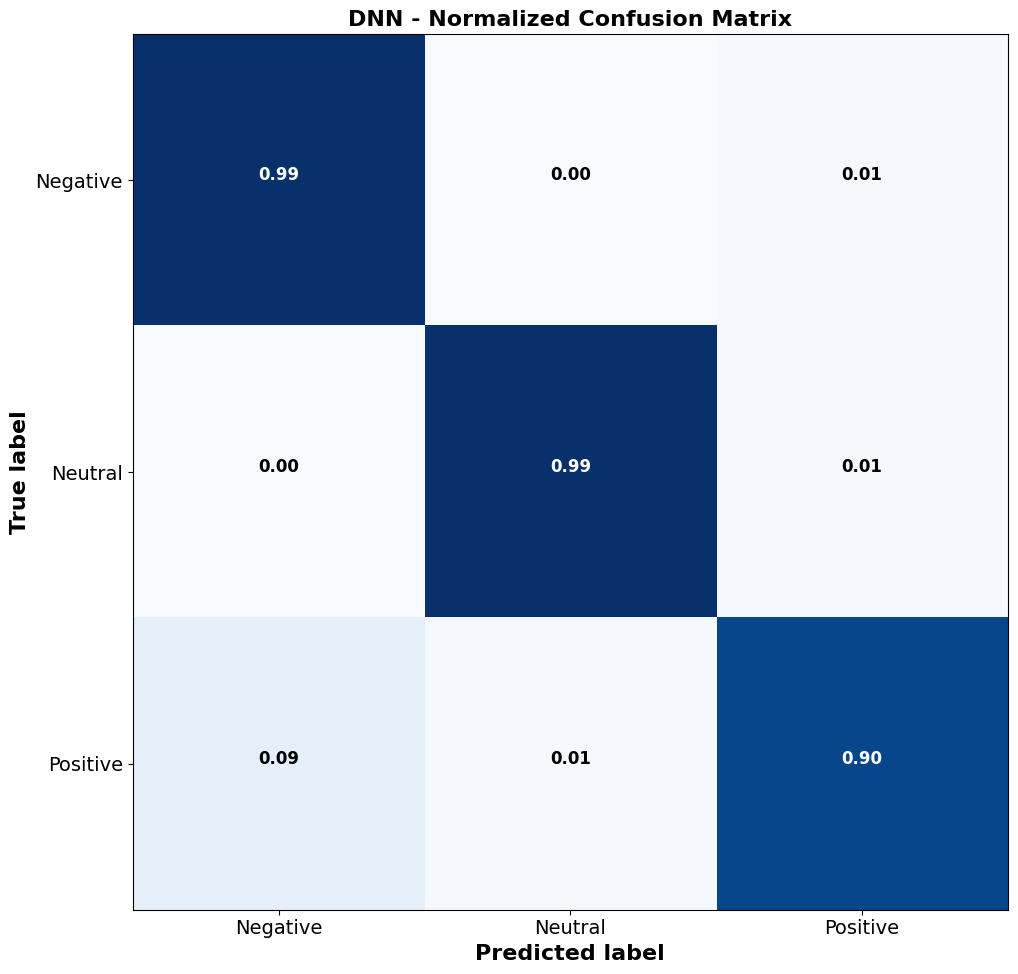

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = cm
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'], normalize=True,
                      title='DNN - Normalized Confusion Matrix')
plt.show()

ROC & AUC 

ROC AUC score: 0.9715508633756703


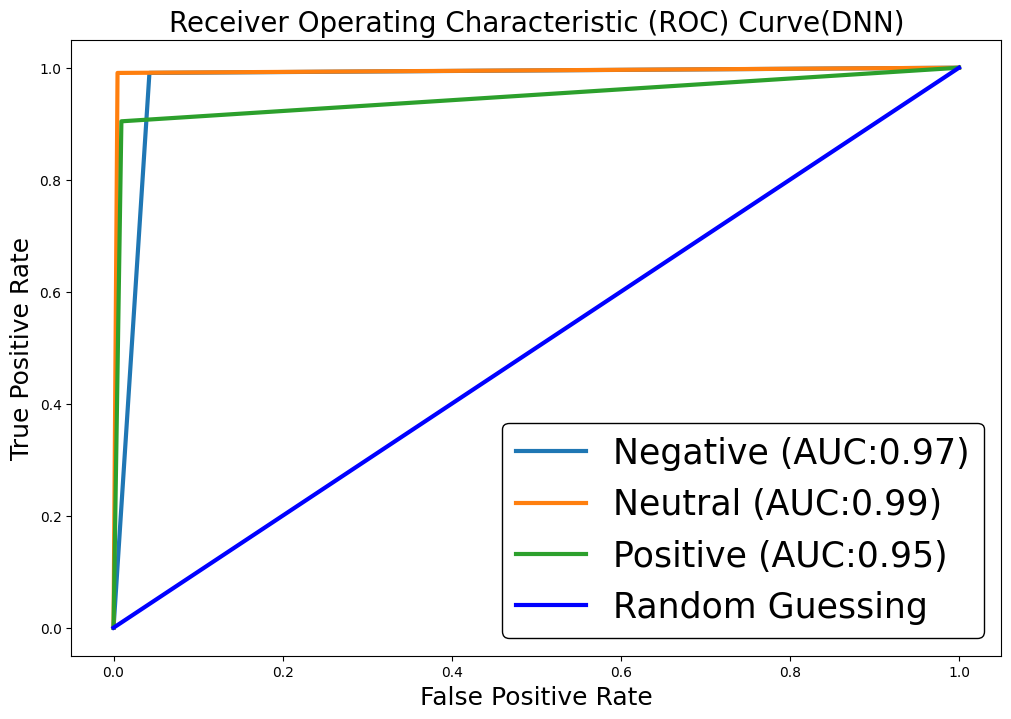

In [63]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(y_test_dnn, y_pred_dnn))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(DNN)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_dnn.png', dpi=300, bbox_inches='tight')
plt.show()


##  CNN-based model

In [64]:
model_cnn = Sequential()
model_cnn.add(Conv1D(64, 5, activation='relu',input_shape=(2548,1)))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(128, 5, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Flatten())
model_cnn.add(Flatten())
model_cnn.add(Dense(256,activation="relu"))
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(3,activation="softmax"))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2544, 64)          384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1272, 64)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1268, 128)         41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 634, 128)         0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 81152)             0         
                                                                 
 flatten_1 (Flatten)         (None, 81152)             0

In [65]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True) 
# adam = Adam(learning_rate=0.001) 
# lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))                           
model_cnn.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001),
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
cnn_h = model_cnn.fit(X_train,y_train,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   epochs=500,
                   callbacks=[es,lr_schedule])

Epoch 1/500
38/38 [==============================] - 7s 34ms/step - loss: 0.8360 - accuracy: 0.6957 - val_loss: 0.6001 - val_accuracy: 0.8294 - lr: 0.0010
Epoch 2/500
38/38 [==============================] - 1s 18ms/step - loss: 0.5441 - accuracy: 0.8533 - val_loss: 0.4464 - val_accuracy: 0.8629 - lr: 9.0484e-04
Epoch 3/500
38/38 [==============================] - 1s 18ms/step - loss: 0.4365 - accuracy: 0.8910 - val_loss: 0.3914 - val_accuracy: 0.8863 - lr: 8.1873e-04
Epoch 4/500
38/38 [==============================] - 1s 19ms/step - loss: 0.3755 - accuracy: 0.8961 - val_loss: 0.3099 - val_accuracy: 0.9164 - lr: 7.4082e-04
Epoch 5/500
38/38 [==============================] - 1s 18ms/step - loss: 0.3261 - accuracy: 0.8994 - val_loss: 0.2761 - val_accuracy: 0.9298 - lr: 6.7032e-04
Epoch 6/500
38/38 [==============================] - 1s 18ms/step - loss: 0.2957 - accuracy: 0.9086 - val_loss: 0.2561 - val_accuracy: 0.9231 - lr: 6.0653e-04
Epoch 7/500
38/38 [==============================]

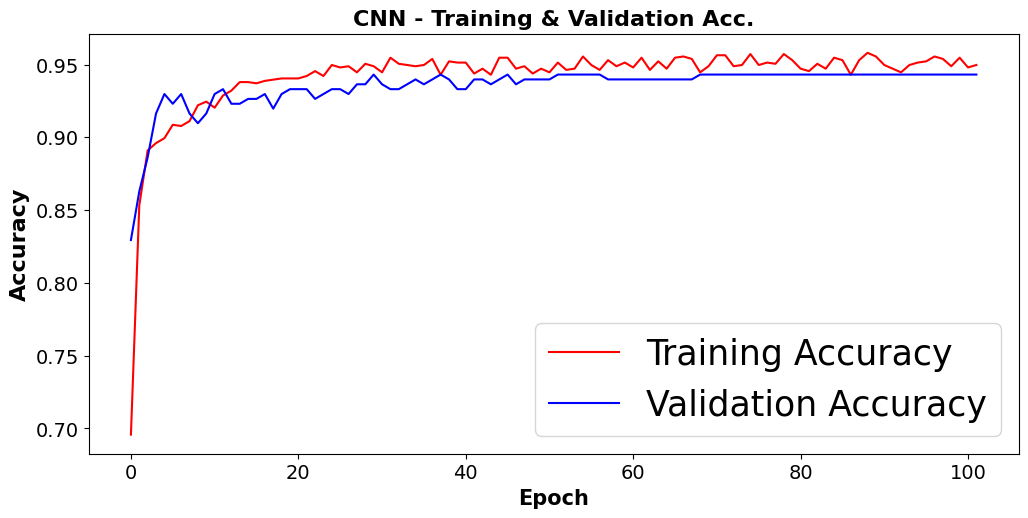

In [66]:
# Show History
acc_his = cnn_h.history['accuracy']
val_acc_his = cnn_h.history['val_accuracy']

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc_his, label='Training Accuracy', color='r')
plt.plot(val_acc_his, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=25)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('CNN - Training & Validation Acc.', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.savefig('t&v_acc_cnn.png', dpi=300, bbox_inches='tight')
plt.show()

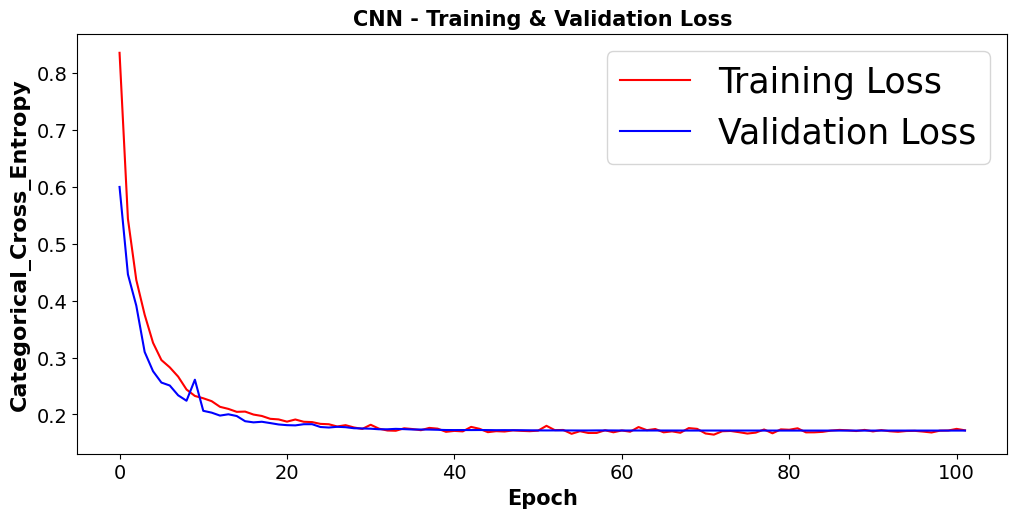

In [67]:

loss_his = cnn_h.history['loss']
val_loss_his = cnn_h.history['val_loss']


plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 2)
plt.plot(loss_his, label='Training Loss', color='r')
plt.plot(val_loss_his, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=25)
plt.ylabel('Categorical_Cross_Entropy', fontsize=16, weight='bold')
plt.title('CNN - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.savefig('t&v_loss_cnn.png', dpi=300, bbox_inches='tight')

plt.show()

In [68]:
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn = np.argmax(y_pred_cnn,axis=1)
y_test_cnn = np.argmax(y_test,axis=1)

cnn_acc = accuracy_score(y_test_cnn,y_pred_cnn)
print("Test Accuracy: {:.3f}%".format(cnn_acc * 100))

20/20 [==============================] - 0s 5ms/step
Test Accuracy: 92.656%


Confusion Matrix:
 [[200   0  26]
 [  0 211   1]
 [ 16   4 182]]


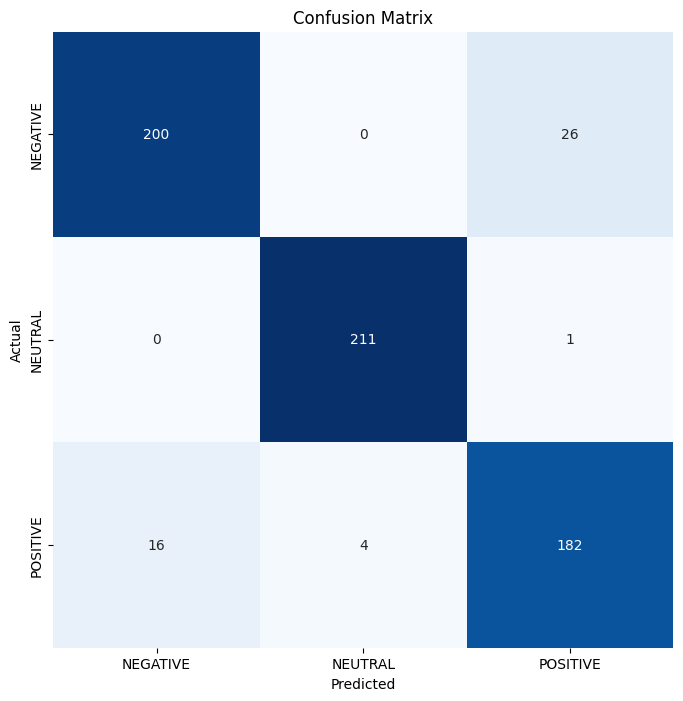

In [69]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_cnn,y_test_cnn)

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [70]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_cnn, y_test_cnn, target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.93      0.88      0.90       226
     NEUTRAL       0.98      1.00      0.99       212
    POSITIVE       0.87      0.90      0.89       202

    accuracy                           0.93       640
   macro avg       0.93      0.93      0.93       640
weighted avg       0.93      0.93      0.93       640



ROC & AUC 

ROC AUC score: 0.944676210616981


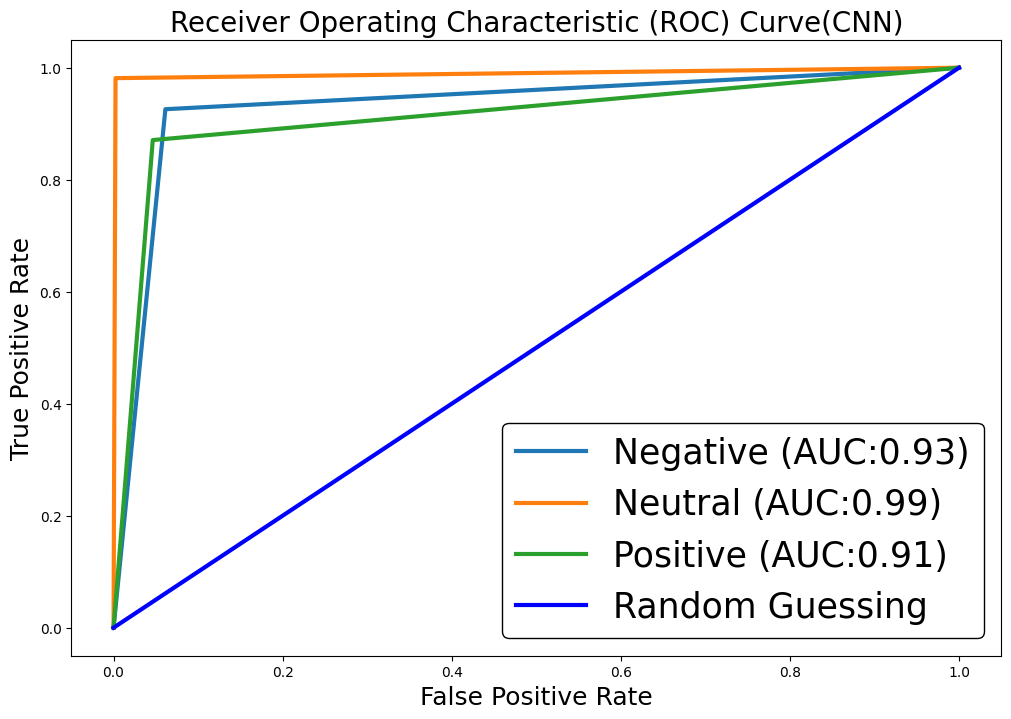

In [71]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(y_test_cnn, y_pred_cnn))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(CNN)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_cnn.png', dpi=300, bbox_inches='tight')
plt.show()

##  LSTM-based model

In [72]:
X_train.shape

(1193, 2548)

In [73]:
X_train_reshape = np.reshape(X_train, (X_train.shape[0],1,x.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0],1,x.shape[1]))

In [74]:
X_train_reshape.shape

(1193, 1, 2548)

In [75]:
#y_test_reshape = to_categorical(y_test, 3)
#y_train_reshape = to_categorical(y_train, 3)

In [76]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()

model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(1,2548),activation="relu",return_sequences=True))
model_lstm.add(Dropout(0.25))
model_lstm.add(LSTM(128,activation="relu"))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.25))
model_lstm.add(Dense(512, activation = 'relu'))
model_lstm.add(Dropout(0.25))
model_lstm.add(Dense(3, activation='softmax'))
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             668928    
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                        

In [77]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
adam = Adam(learning_rate=0.001) 
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.)) 
model_lstm.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
lstm_h = model_lstm.fit(X_train_reshape,y_train,
                   batch_size=32,
                   validation_data=(X_test_reshape, y_test),
                   epochs=500,
                   callbacks=[es,lr_schedule])

Epoch 1/500
38/38 [==============================] - 6s 23ms/step - loss: 0.4335 - accuracy: 0.8391 - val_loss: 0.4155 - val_accuracy: 0.8797 - lr: 0.0010
Epoch 2/500
38/38 [==============================] - 1s 13ms/step - loss: 0.2610 - accuracy: 0.9003 - val_loss: 0.2661 - val_accuracy: 0.9234 - lr: 9.0484e-04
Epoch 3/500
38/38 [==============================] - 0s 13ms/step - loss: 0.2224 - accuracy: 0.9229 - val_loss: 0.2098 - val_accuracy: 0.9328 - lr: 8.1873e-04
Epoch 4/500
38/38 [==============================] - 0s 13ms/step - loss: 0.1716 - accuracy: 0.9338 - val_loss: 0.1998 - val_accuracy: 0.9453 - lr: 7.4082e-04
Epoch 5/500
38/38 [==============================] - 0s 13ms/step - loss: 0.1331 - accuracy: 0.9514 - val_loss: 0.1466 - val_accuracy: 0.9547 - lr: 6.7032e-04
Epoch 6/500
38/38 [==============================] - 0s 13ms/step - loss: 0.0953 - accuracy: 0.9723 - val_loss: 0.1246 - val_accuracy: 0.9672 - lr: 6.0653e-04
Epoch 7/500
38/38 [==============================]

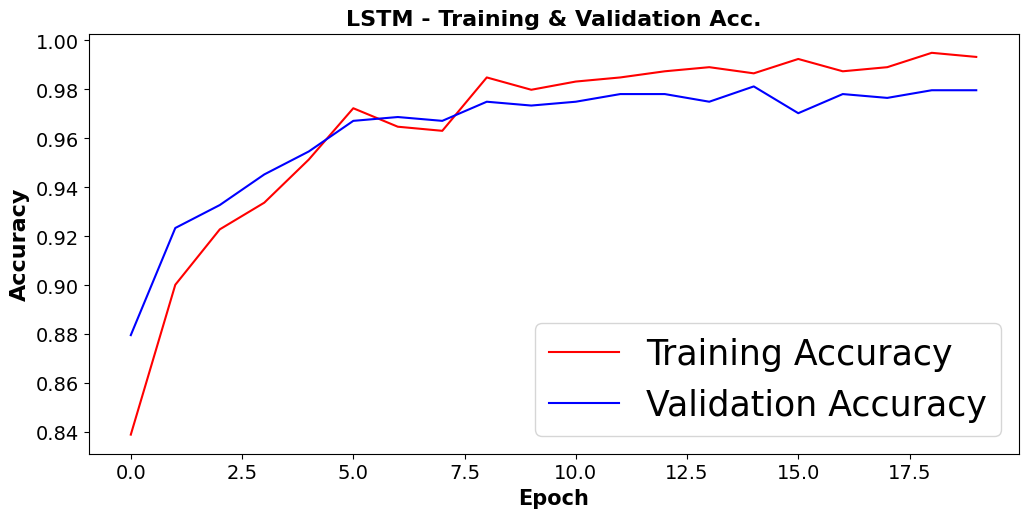

In [78]:
# Show History
acc_his = lstm_h.history['accuracy']
val_acc_his = lstm_h.history['val_accuracy']

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc_his, label='Training Accuracy', color='r')
plt.plot(val_acc_his, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=25)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Acc.', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.savefig('t&v_acc_lstm.png', dpi=300, bbox_inches='tight')
plt.show()


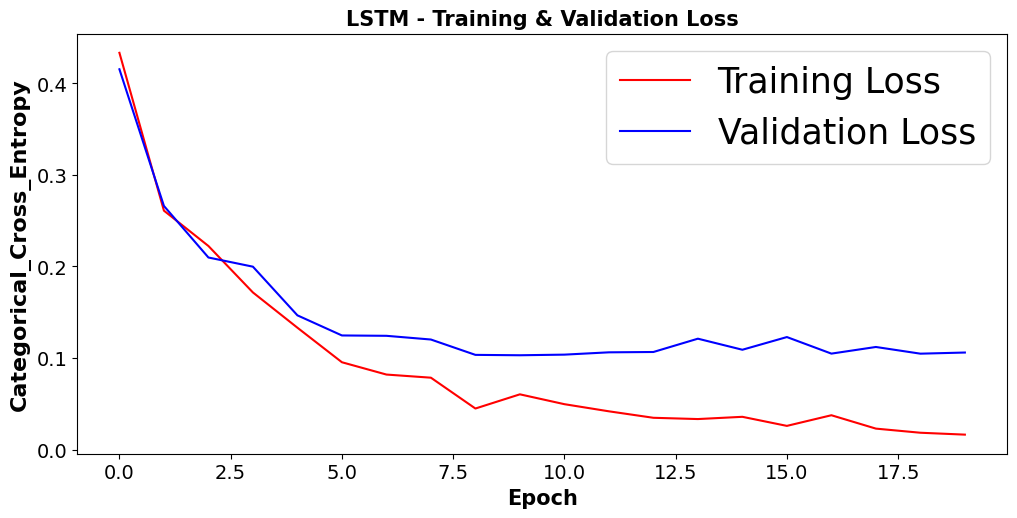

In [79]:
loss_his = lstm_h.history['loss']
val_loss_his = lstm_h.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 2)
plt.plot(loss_his, label='Training Loss', color='r')
plt.plot(val_loss_his, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=25)
plt.ylabel('Categorical_Cross_Entropy', fontsize=16, weight='bold')
plt.title('LSTM - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.savefig('t&v_loss_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

In [80]:
from sklearn.metrics import accuracy_score
y_pred_lstm = model_lstm.predict(X_test_reshape)
y_pred_lstm = np.argmax(y_pred_lstm,axis=1)
y_test_lstm = np.argmax(y_test,axis=1)

lstm_acc = accuracy_score(y_test_lstm,y_pred_lstm)
print("Test Accuracy: {:.3f}%".format(lstm_acc * 100))

20/20 [==============================] - 0s 2ms/step
Test Accuracy: 97.344%


Confusion Matrix:
 [[211   0   5]
 [  0 211   4]
 [  8   0 201]]


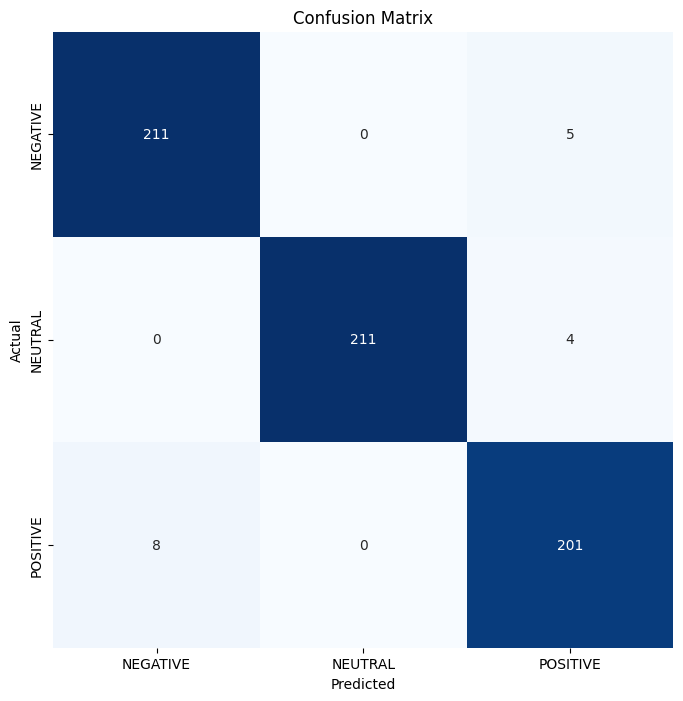

In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_lstm,y_pred_lstm)

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [82]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_lstm,y_test_lstm, target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.96      0.97       219
     NEUTRAL       0.98      1.00      0.99       211
    POSITIVE       0.96      0.96      0.96       210

    accuracy                           0.97       640
   macro avg       0.97      0.97      0.97       640
weighted avg       0.97      0.97      0.97       640



ROC & AUC

ROC AUC score: 0.9800366822775657


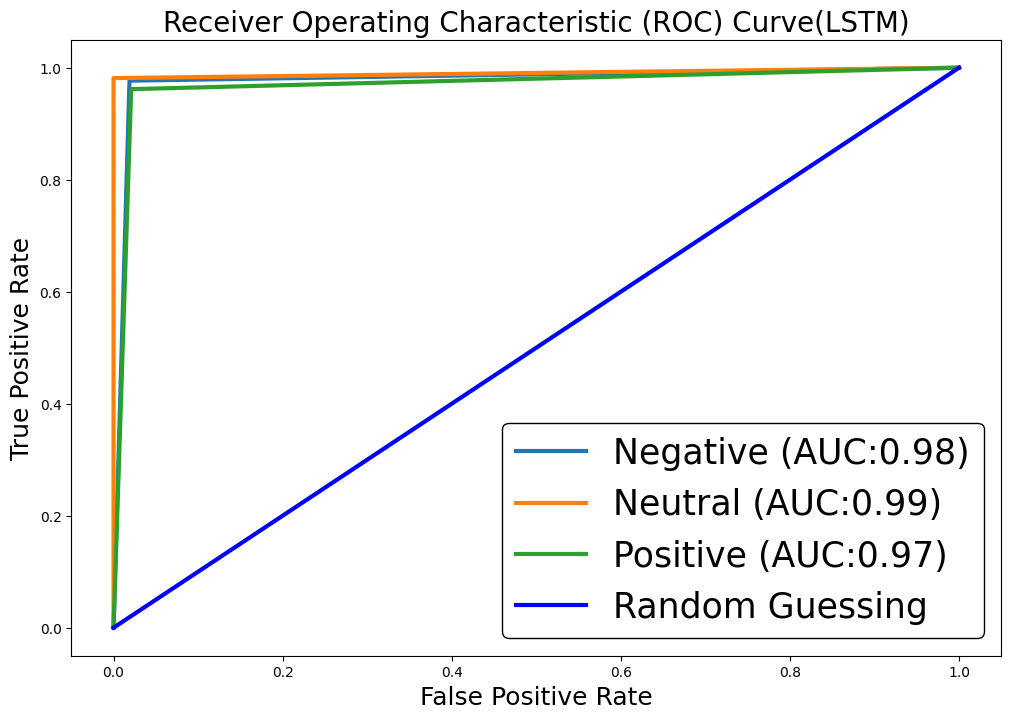

In [83]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(y_test_lstm, y_pred_lstm))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(LSTM)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_lstm.png', dpi=300, bbox_inches='tight')
plt.show()

##  GRU-based model

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al. The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate.

In [84]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))
expand_dims = tf.expand_dims(inputs, axis=2)
gru = tf.keras.layers.GRU(256, return_sequences=True)(expand_dims)
flatten = tf.keras.layers.Flatten()(gru)
outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)
model_gru = tf.keras.Model(inputs=inputs, outputs=outputs)
model_gru.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2548)]            0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 2548, 1)          0         
                                                                 
 gru (GRU)                   (None, 2548, 256)         198912    
                                                                 
 flatten (Flatten)           (None, 652288)            0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1956867   
                                                                 
Total params: 2,155,779
Trainable params: 2,155,779
Non-trainable params: 0
_________________________________________________________________


In [85]:
model_gru.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [86]:

gru_h = model_gru.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=500,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            mode='min',
            verbose=1,
            patience=10, 
            restore_best_weights=True
        )
    ]
)

Epoch 1/500
30/30 [==============================] - 7s 148ms/step - loss: 0.7418 - accuracy: 0.8229 - val_loss: 0.8184 - val_accuracy: 0.8326
Epoch 2/500
30/30 [==============================] - 4s 125ms/step - loss: 0.2709 - accuracy: 0.9130 - val_loss: 0.3059 - val_accuracy: 0.8703
Epoch 3/500
30/30 [==============================] - 3s 114ms/step - loss: 0.2423 - accuracy: 0.9245 - val_loss: 0.5704 - val_accuracy: 0.8912
Epoch 4/500
30/30 [==============================] - 3s 114ms/step - loss: 0.1178 - accuracy: 0.9486 - val_loss: 0.2627 - val_accuracy: 0.8828
Epoch 5/500
30/30 [==============================] - 4s 126ms/step - loss: 0.0622 - accuracy: 0.9853 - val_loss: 0.2620 - val_accuracy: 0.9163
Epoch 6/500
30/30 [==============================] - 4s 123ms/step - loss: 0.0335 - accuracy: 0.9958 - val_loss: 0.2737 - val_accuracy: 0.9163
Epoch 7/500
30/30 [==============================] - 3s 115ms/step - loss: 0.0203 - accuracy: 0.9990 - val_loss: 0.2555 - val_accuracy: 0.9163

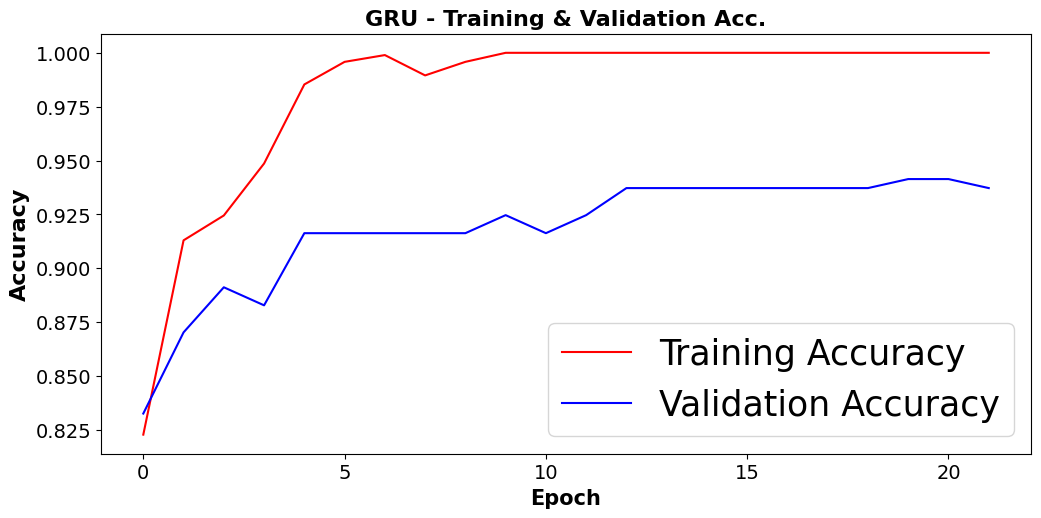

In [87]:
# Show History
acc_his = gru_h.history['accuracy']
val_acc_his = gru_h.history['val_accuracy']

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc_his, label='Training Accuracy', color='r')
plt.plot(val_acc_his, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=25)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('GRU - Training & Validation Acc.', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.savefig('t&v_acc_gru.png', dpi=300, bbox_inches='tight')
plt.show()


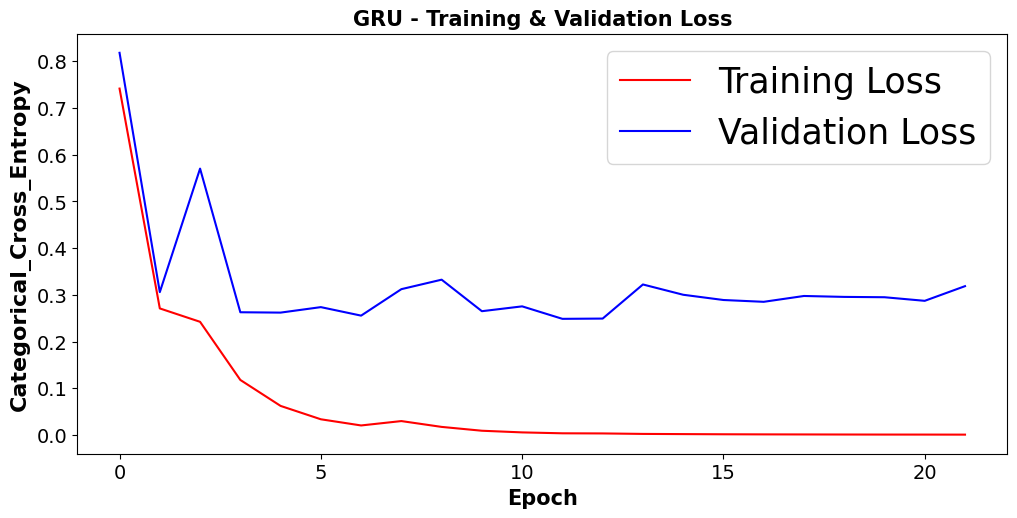

In [88]:
loss_his = gru_h.history['loss']
val_loss_his = gru_h.history['val_loss']
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 2)
plt.plot(loss_his, label='Training Loss', color='r')
plt.plot(val_loss_his, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=25)
plt.ylabel('Categorical_Cross_Entropy', fontsize=16, weight='bold')
plt.title('GRU - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.savefig('t&v_loss_gru.png', dpi=300, bbox_inches='tight')
plt.show()

In [89]:
from sklearn.metrics import accuracy_score
y_pred_gru = model_gru.predict(X_test)
y_pred_gru = np.argmax(y_pred_gru,axis=1)
y_test_gru = np.argmax(y_test,axis=1)
gru_acc = accuracy_score(y_test_gru,y_pred_gru)
print("Test Accuracy: {:.3f}%".format(gru_acc * 100))

20/20 [==============================] - 1s 48ms/step
Test Accuracy: 94.844%


Confusion Matrix:
 [[203   0  13]
 [  0 213   2]
 [ 16   2 191]]


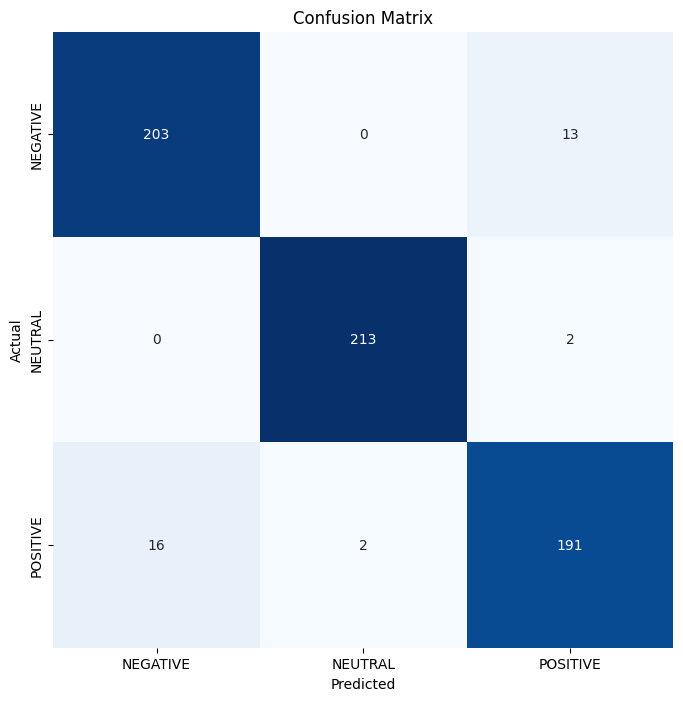

In [90]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_gru, y_pred_gru)

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [91]:
from sklearn.metrics import classification_report
clr = classification_report(y_test_gru, y_pred_gru, target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.93      0.94      0.93       216
     NEUTRAL       0.99      0.99      0.99       215
    POSITIVE       0.93      0.91      0.92       209

    accuracy                           0.95       640
   macro avg       0.95      0.95      0.95       640
weighted avg       0.95      0.95      0.95       640



ROC & AUC

ROC AUC score: 0.9611905952812102


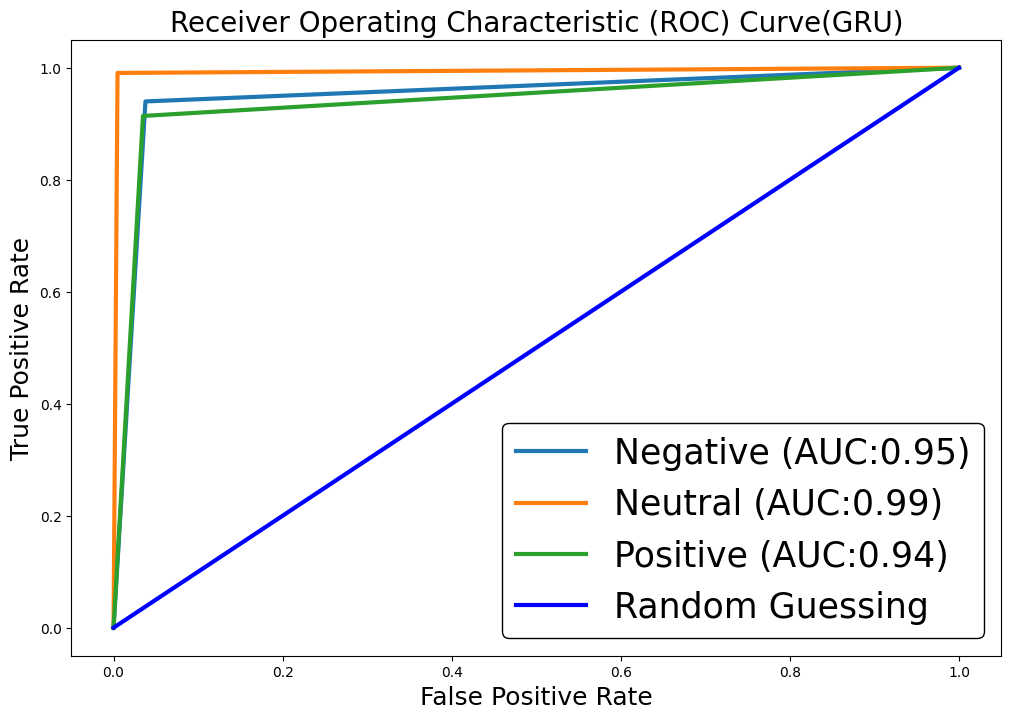

In [92]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(y_test_gru, y_pred_gru))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(GRU)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_gru.png', dpi=300, bbox_inches='tight')
plt.show()

## Hybrid model(h) 

In [101]:

# hyperparameter_space = {
#     'learning_rate': [0.001, 0.01],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'batch_size': [16, 32, 64],
# #     'num_filters': [32, 64, 128],
# #     'num_lstm_units': [64, 128, 256],
#     'pool_size':[2,3,4,5],
#     'kernel_size':[2,3,4,5],
    
# }

# #Create a function that builds the CNN+LSTM model with the specified hyperparameters
# def create_model(learning_rate, dropout_rate,kernel_size,pool_size):
    
#     model_h = Sequential()
#     model_h.add(Conv1D(64, kernel_size, activation='relu', input_shape=(2548,1)))
#     model_h.add(MaxPooling1D(pool_size=2))
#     model_h.add(Conv1D(128, kernel_size=3, activation='relu'))
#     model_h.add(MaxPooling1D(pool_size))
#     model_h.add(Dropout(dropout_rate))
#     model_h.add(LSTM(64,return_sequences=True))
#     model_h.add(BatchNormalization())
#     model_h.add(Dropout(dropout_rate))
#     model_h.add(LSTM(128,return_sequences=True))
#     model_h.add(BatchNormalization())
#     model_h.add(Dropout(dropout_rate))
#     model_h.add(Flatten())
#     model_h.add(Dense(512, activation = 'relu'))
#     model_h.add(Dropout(dropout_rate))
#     model_h.add(Dense(3, activation='softmax'))
#     model_h.summary()
#     optimizer = Adam(learning_rate=learning_rate)
#     model_h.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#     return model_h

# from sklearn.model_selection import RandomizedSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier

# model_h = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)
# random_search = RandomizedSearchCV(estimator=model_h, param_distributions=hyperparameter_space, n_iter=10, cv=3)

# random_search.fit(X_train, y_train)
# print('Best params:', random_search.best_params_)
# print('Best score:', random_search.best_score_)

In [102]:
# model_h = Sequential()
# model_h.add(Conv1D(64, 5, activation='relu',input_shape=(2548,1)))
# # model.add(MaxPooling1D(2))
# model_h.add(Conv1D(128, 5, activation='relu'))
# # model.add(MaxPooling1D(2))
# # model.add(LSTM(units=64, return_sequences=True))
# # model.add(Dropout(0.25))
# # model.add(LSTM(units=128, return_sequences=False))
# # model.add(Dropout(0.25))
# # model.add(Flatten())
# # model.add(Dense(512,activation="relu"))
# # model.add(Dropout(0.25))
# # model.add(Dense(3,activation="softmax"))
# # model.summary()
# # model.add(Reshape((634,128)))
# model_h.add(LSTM(64,return_sequences=True))
# model_h.add(BatchNormalization())
# model_h.add(Dropout(0.4))
# model_h.add(LSTM(128,return_sequences=True))
# model_h.add(BatchNormalization())
# model_h.add(Dropout(0.4))
# model_h.add(Flatten())
# model_h.add(Dense(512, activation = 'relu'))
# model_h.add(Dropout(0.4))
# model_h.add(Dense(3, activation='softmax'))
# model_h.summary()

model_hybrid = Sequential()
model_hybrid.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(2548,1)))
model_hybrid.add(Conv1D(128, kernel_size=5, activation='relu'))
model_hybrid.add(MaxPooling1D(pool_size=3))
model_hybrid.add(Dropout(0.4))
model_hybrid.add(LSTM(64,return_sequences=True))
model_hybrid.add(Dropout(0.4))
model_hybrid.add(LSTM(128,return_sequences=True))
model_hybrid.add(BatchNormalization())
model_hybrid.add(Dropout(0.4))
model_hybrid.add(Flatten())
model_hybrid.add(Dense(512, activation = 'relu'))
model_hybrid.add(Dropout(0.4))
model_hybrid.add(Dense(3, activation='softmax'))
model_hybrid.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2544, 64)          384       
                                                                 
 conv1d_3 (Conv1D)           (None, 2540, 128)         41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 846, 128)         0         
 )                                                               
                                                                 
 dropout_6 (Dropout)         (None, 846, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 846, 64)           49408     
                                                                 
 dropout_7 (Dropout)         (None, 846, 64)           0         
                                                      

In [103]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
adam = Adam(learning_rate=0.001) 
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.)) 
model_hybrid.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
hybrid_his = model_hybrid.fit(X_train,y_train,
                   batch_size=64,
                   validation_data=(X_val, y_val),
                   epochs=500,
                   callbacks=[es,lr_schedule])

Epoch 1/500
19/19 [==============================] - 9s 201ms/step - loss: 7.8451 - accuracy: 0.7871 - val_loss: 8.4496 - val_accuracy: 0.3278 - lr: 0.0010
Epoch 2/500
19/19 [==============================] - 2s 127ms/step - loss: 1.7531 - accuracy: 0.8734 - val_loss: 7.1186 - val_accuracy: 0.3813 - lr: 9.0484e-04
Epoch 3/500
19/19 [==============================] - 2s 126ms/step - loss: 0.5620 - accuracy: 0.9028 - val_loss: 6.9908 - val_accuracy: 0.3746 - lr: 8.1873e-04
Epoch 4/500
19/19 [==============================] - 2s 125ms/step - loss: 0.1593 - accuracy: 0.9396 - val_loss: 5.9690 - val_accuracy: 0.3378 - lr: 7.4082e-04
Epoch 5/500
19/19 [==============================] - 2s 132ms/step - loss: 0.1837 - accuracy: 0.9464 - val_loss: 4.9023 - val_accuracy: 0.3311 - lr: 6.7032e-04
Epoch 6/500
19/19 [==============================] - 2s 120ms/step - loss: 0.1412 - accuracy: 0.9531 - val_loss: 5.4435 - val_accuracy: 0.3913 - lr: 6.0653e-04
Epoch 7/500
19/19 [=========================

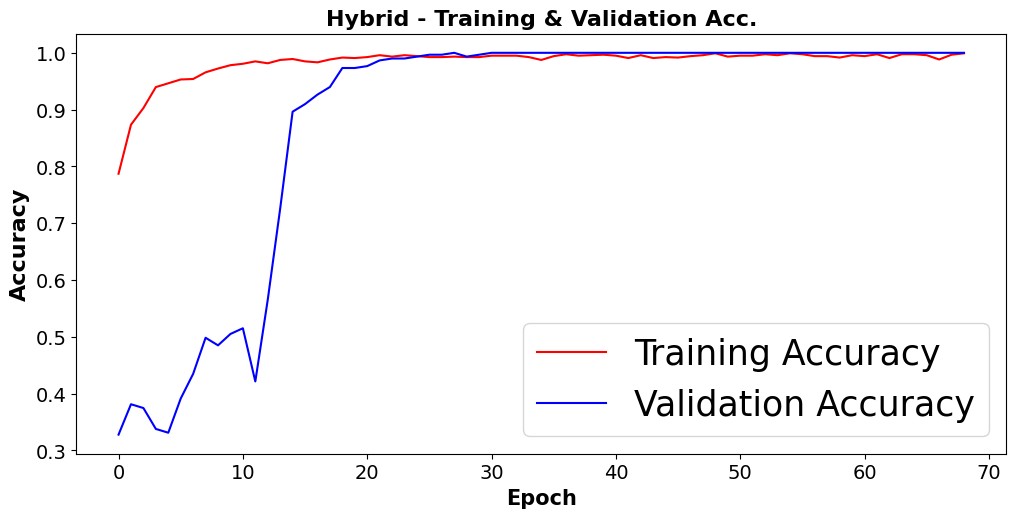

In [104]:
# Show History
acc_his = hybrid_his.history['accuracy']
val_acc_his = hybrid_his.history['val_accuracy']

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc_his, label='Training Accuracy', color='r')
plt.plot(val_acc_his, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=25)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Hybrid - Training & Validation Acc.', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.savefig('t&v_acc_h.png', dpi=300, bbox_inches='tight')
plt.show()


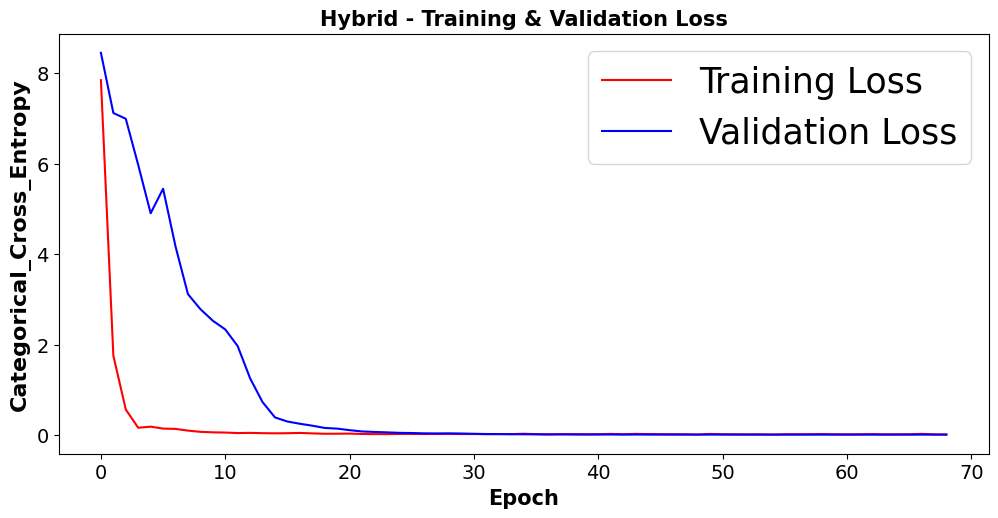

In [105]:
loss_his = hybrid_his.history['loss']
val_loss_his = hybrid_his.history['val_loss']
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 2)
plt.plot(loss_his, label='Training Loss', color='r')
plt.plot(val_loss_his, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=25)
plt.ylabel('Categorical_Cross_Entropy', fontsize=16, weight='bold')
plt.title('Hybrid - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.savefig('t&v_loss_h.png', dpi=300, bbox_inches='tight')
plt.show()

In [106]:
from sklearn.metrics import accuracy_score
y_pred_h= model_hybrid.predict(X_test)
y_pred_h = np.argmax(y_pred_h,axis=1)
y_test_h=np.argmax(y_test,axis=1)
hybrid_accuracy = accuracy_score(y_test_h,y_pred_h)
print("Test Accuracy of Hybrid Model : {:.3f}%".format(hybrid_accuracy * 100))

20/20 [==============================] - 2s 29ms/step
Test Accuracy of Hybrid Model : 98.750%


Confusion Matrix:
 [[211   0   5]
 [  0 213   2]
 [  0   1 208]]


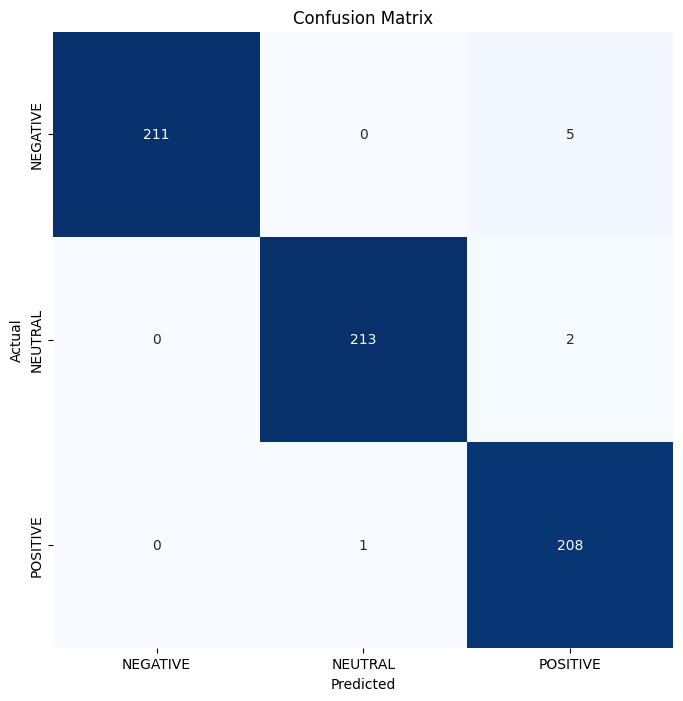

In [107]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_h,y_pred_h)

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [108]:
from sklearn.metrics import classification_report
clr = classification_report(y_pred_h, y_test_h, target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      1.00      0.99       211
     NEUTRAL       0.99      1.00      0.99       214
    POSITIVE       1.00      0.97      0.98       215

    accuracy                           0.99       640
   macro avg       0.99      0.99      0.99       640
weighted avg       0.99      0.99      0.99       640



ROC AUC score: 0.9906950994658045


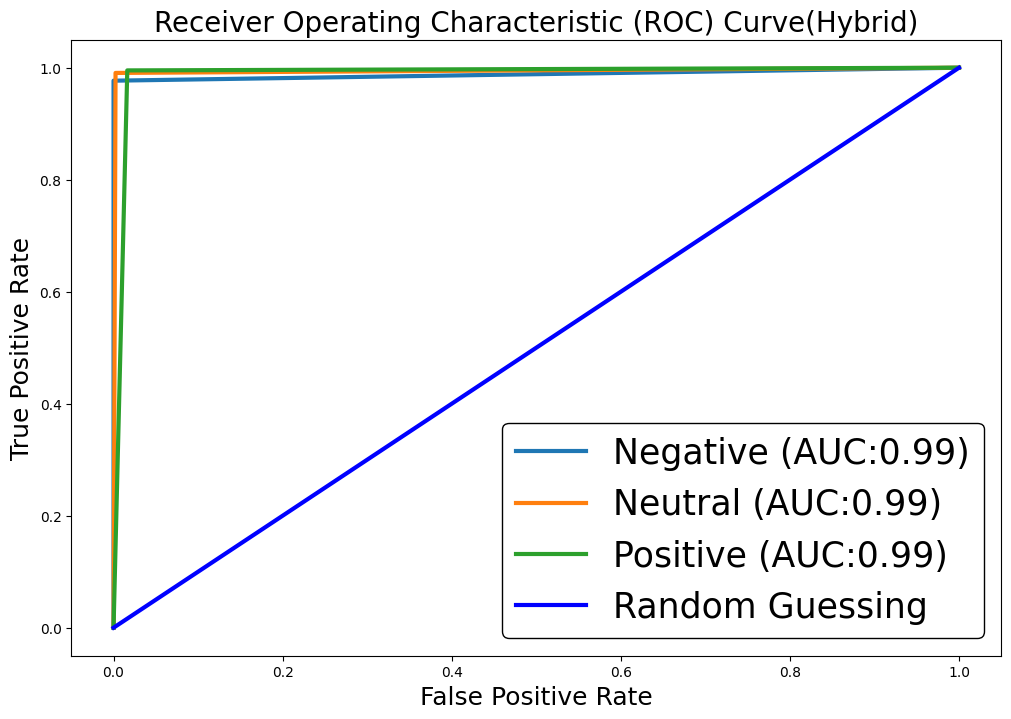

In [109]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(y_test_h, y_pred_h))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(Hybrid)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_h.png', dpi=300, bbox_inches='tight')
plt.show()

## Ensemble Learning(Voting)

In [132]:
y_test_ensemble=np.argmax(y_test,axis=1)

In [133]:
len=y_test_ensemble.shape[0]

In [134]:
y_pred_cnn

array([1, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1,
       0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 2, 1,
       2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 0,
       0, 0, 1, 2, 0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       2, 2, 0, 0, 0, 2, 1, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 2, 2,
       0, 2, 2, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 0, 0,
       2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 1, 2, 0,
       0, 1, 0, 2, 1, 1, 2, 0, 1, 2, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0,
       2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 1, 0, 1,
       1, 0, 2, 2, 2, 1, 0, 0, 0, 2, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 1,
       2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 0, 2,
       2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 2, 2, 1, 0,

In [135]:
y_pred_lstm

array([1, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1,
       0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 2, 1,
       2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 0,
       0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       2, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 2, 2,
       0, 2, 2, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 1, 2, 0,
       2, 1, 2, 2, 1, 1, 2, 0, 1, 2, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0,
       2, 1, 0, 1, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 1, 0, 1,
       2, 0, 1, 2, 0, 1, 2, 0, 0, 2, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 1,
       2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 2,
       2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 2, 2, 2, 1, 0,

In [136]:
y_pred_h

array([1, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1,
       0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 0, 1, 2, 1,
       2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 2, 2,
       0, 2, 2, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 1, 2, 0,
       2, 1, 2, 2, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0,
       2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 1, 0, 1,
       1, 0, 2, 2, 0, 1, 2, 0, 0, 2, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 1,
       2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 2,
       2, 0, 0, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 0,

In [137]:
acc_cnn=cnn_acc*100
print(acc_cnn)
acc_lstm=lstm_acc*100
print(acc_lstm)
accuracy_hybrid=hybrid_accuracy*100
print(accuracy_hybrid)

92.65625
97.34375
98.75


In [138]:
y_ensemble = np.zeros(len, dtype=int)
for i in range(len):
    cnt0, cnt1, cnt2 = 0, 0, 0
    
    if y_pred_cnn[i] == 0:
        cnt0 += 1
    elif y_pred_cnn[i] == 1:
        cnt1 += 1
    else:
        cnt2 += 1
        
    if y_pred_lstm[i] == 0:
        cnt0 += 1
    elif y_pred_lstm[i] == 1:
        cnt1 += 1
    else:
        cnt2 += 1
        
    if y_pred_h[i] == 0:
        cnt0 += 1
    elif y_pred_h[i] == 1:
        cnt1 += 1
    else:
        cnt2 += 1
        
    if cnt0 >= 2:
        y_ensemble[i] = 0
    elif cnt1 >= 2:
        y_ensemble[i] = 1
    elif cnt2 >= 2:
        y_ensemble[i] = 2
    else:
        if acc_lstm > acc_cnn and acc_lstm > accuracy_hybrid:
            y_ensemble[i] = y_pred_lstm[i]
        elif accuracy_hybrid > acc_lstm and accuracy_hybrid > acc_cnn:
            y_ensemble[i] = y_pred_h[i]
        else:
            y_ensemble[i] = y_pred_cnn[i]


In [139]:
y_ensemble

array([1, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1,
       0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 1, 2, 1,
       2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 2, 0,
       0, 0, 1, 2, 0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       2, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 2, 2,
       0, 2, 2, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 1, 2, 0,
       2, 1, 2, 2, 1, 1, 2, 0, 1, 2, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0,
       2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 1, 0, 1,
       1, 0, 2, 2, 0, 1, 2, 0, 0, 2, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 1,
       2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 2,
       2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 2, 2, 2, 1, 0,

In [140]:
ensemble_acc = accuracy_score(y_test_ensemble,y_ensemble)
print("Test Accuracy: {:.3f}%".format(ensemble_acc * 100))

Test Accuracy: 97.500%


In [141]:
cnn_acc = accuracy_score(y_test_cnn,y_pred_cnn)
print("Test Accuracy: {:.3f}%".format(cnn_acc * 100))

Test Accuracy: 92.656%


In [142]:
lstm_acc = accuracy_score(y_test_cnn,y_pred_lstm)
print("Test Accuracy: {:.3f}%".format(lstm_acc * 100))

Test Accuracy: 97.344%


In [143]:
hybrid_acc = accuracy_score(y_test_cnn,y_pred_h)
print("Test Accuracy: {:.3f}%".format(hybrid_accuracy * 100))

Test Accuracy: 98.750%


Confusion Matrix:
 [[210   0   6]
 [  0 211   4]
 [  6   0 203]]


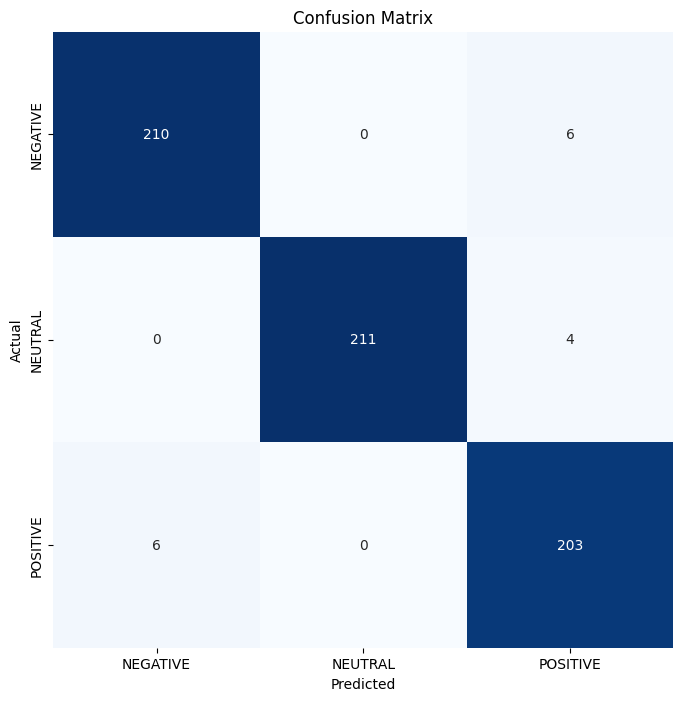

In [144]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_ensemble,y_ensemble)

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [145]:
from sklearn.metrics import classification_report
clr = classification_report(y_test_ensemble, y_ensemble, target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.97      0.97       216
     NEUTRAL       1.00      0.98      0.99       215
    POSITIVE       0.95      0.97      0.96       209

    accuracy                           0.97       640
   macro avg       0.98      0.97      0.97       640
weighted avg       0.98      0.97      0.98       640



ROC & AUC 

ROC AUC score: 0.9812594395905703


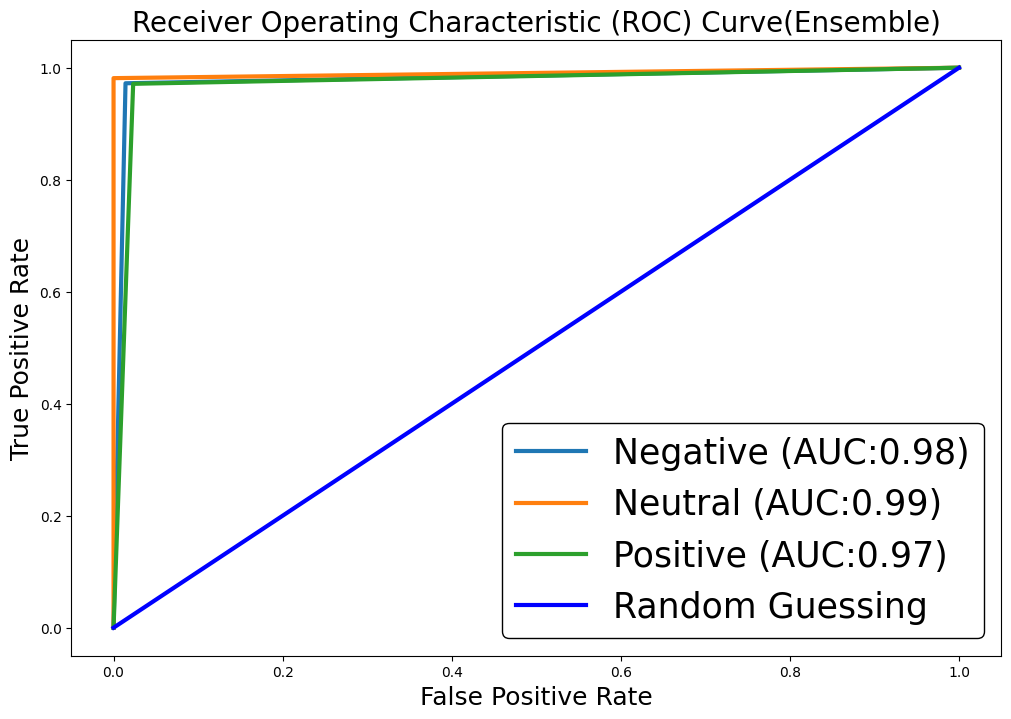

In [146]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(y_test_ensemble, y_ensemble))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(Ensemble)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

## Ensemble Learning Model(Stacking)

In [147]:
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb
# import numpy as np

# pipe = Pipeline(steps=[
#     ('scaler', StandardScaler()),
#     ('xgboost', xgb.XGBClassifier(objective='multi:softmax', num_class=3))
# ])

# # Define the parameter distributions to sample from
# param_dist = {
#     'xgboost__learning_rate': np.arange(0.1, 0.4, 0.05),
#     'xgboost__max_depth': np.arange(3, 8),
#     'xgboost__n_estimators': [50, 100, 200, 500]
# }

# # Create the RandomizedSearchCV object
# random_search = RandomizedSearchCV(pipe, param_distributions=param_dist, cv=3, n_iter=10)

# # Fit the RandomizedSearchCV object to the data
# random_search.fit(X_train, np.argmax(y_train, axis=1))

# # Print the best hyperparameters
# print("Best parameters: {}".format(random_search.best_params_))

# # Evaluate the model with the best hyperparameters on the test set
# accuracy = random_search.score(X_test, np.argmax(y_test,axis=1))
# print("Accuracy: {:.2f}%".format(accuracy * 100))

In [148]:
from xgboost import XGBClassifier
X_val_reshape=np.reshape(X_val,(X_val.shape[0],1,x.shape[1]))

# model_c.fit(X_train,y_train,
#                    batch_size=32,
#                    validation_data=(X_val, y_val),
#                    epochs=500,
#                    callbacks=[es,lr_schedule])
# model_l.fit(X_train_reshape,y_train,
#                    batch_size=32,
#                    validation_data=(X_val_reshape, y_val),
#                    epochs=500,
#                    callbacks=[es,lr_schedule])
# model_h.fit(X_train,y_train,
#                    batch_size=32,
#                    validation_data=(X_val, y_val),
#                    epochs=500,
#                    callbacks=[es,lr_schedule])
# Generate predictions for the validation set using each base model
preds_cnn = model_cnn.predict(X_val)
preds_lstm = model_lstm.predict(X_val_reshape)
preds_hybrid = model_hybrid.predict(X_val)
# Stack the predictions of the base models into a new feature matrix
X_stack = np.column_stack((preds_cnn, preds_lstm, preds_hybrid))
# clf_lvl2 = DecisionTreeClassifier()
# clf_lvl2=RandomForestClassifier(n_estimators = 50, random_state = 0)


xgb_clf = XGBClassifier(
    objective='multi:softmax', 
    num_class=3, 
    n_estimators=500,
    max_depth=6,
    learning_rate=0.25000000000000006
)

# Define the pipeline with the XGBClassifier step
clf_lvl2 = Pipeline([
    ('xgboost', xgb_clf)
])

# clf_lvl2=Pipeline(steps=[('xgboost',xgb.XGBClassifier(objective='multi:softmax', num_class=3))])


clf_lvl2.fit(X_stack, np.argmax(y_val,axis=1))
# Generate predictions for the test set using the base models
test_preds_cnn = model_cnn.predict(X_test)
test_preds_lstm = model_lstm.predict(X_test_reshape)
test_preds_hybrid = model_hybrid.predict(X_test)
# Stack the predictions of the base models for the test set into a new feature matrix
X_test_stack = np.column_stack((test_preds_cnn, test_preds_lstm, test_preds_hybrid))
# Generate final predictions using the meta-model
y_ensemble_s = clf_lvl2.predict(X_test_stack)

20/20 [==============================] - 1s 25ms/step


In [149]:
y_ensemble_s

array([1, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1, 0, 0, 2, 2, 1, 1,
       0, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 2, 0, 1, 2, 1,
       2, 1, 1, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 2, 2,
       0, 2, 2, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 1, 0, 0, 2, 2, 0, 2, 1, 0, 0, 2, 0, 1, 0, 1, 2, 1, 2, 1, 2, 0,
       2, 1, 2, 2, 1, 1, 2, 0, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0,
       2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 1, 0, 1,
       1, 0, 1, 2, 0, 1, 2, 0, 0, 2, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0,
       0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 0, 1,
       2, 2, 2, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 2,
       2, 0, 0, 2, 1, 0, 2, 1, 1, 2, 2, 2, 2, 1, 0,

In [150]:
y_test_ensemble_s=np.argmax(y_test,axis=1)

In [151]:
ensemble_acc_st = accuracy_score(y_test_ensemble_s,y_ensemble_s)
print("Test Accuracy: {:.3f}%".format(ensemble_acc_st * 100))

Test Accuracy: 98.906%


Confusion Matrix:
 [[211   0   5]
 [  0 214   1]
 [  0   1 208]]


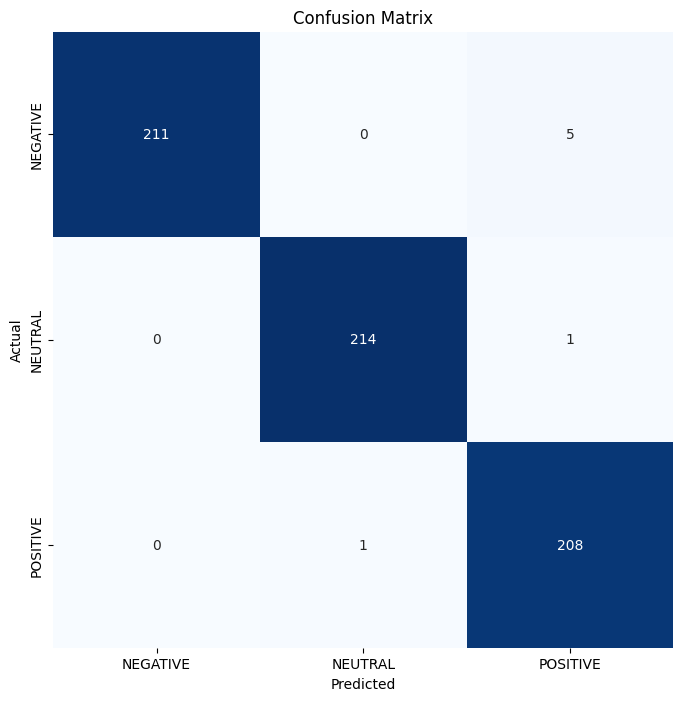

In [153]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_ensemble_s,y_ensemble_s)

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [154]:
from sklearn.metrics import classification_report
clr = classification_report(y_test_ensemble_s, y_ensemble_s, target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       1.00      0.98      0.99       216
     NEUTRAL       1.00      1.00      1.00       215
    POSITIVE       0.97      1.00      0.98       209

    accuracy                           0.99       640
   macro avg       0.99      0.99      0.99       640
weighted avg       0.99      0.99      0.99       640



ROC AUC score: 0.9918569908667288


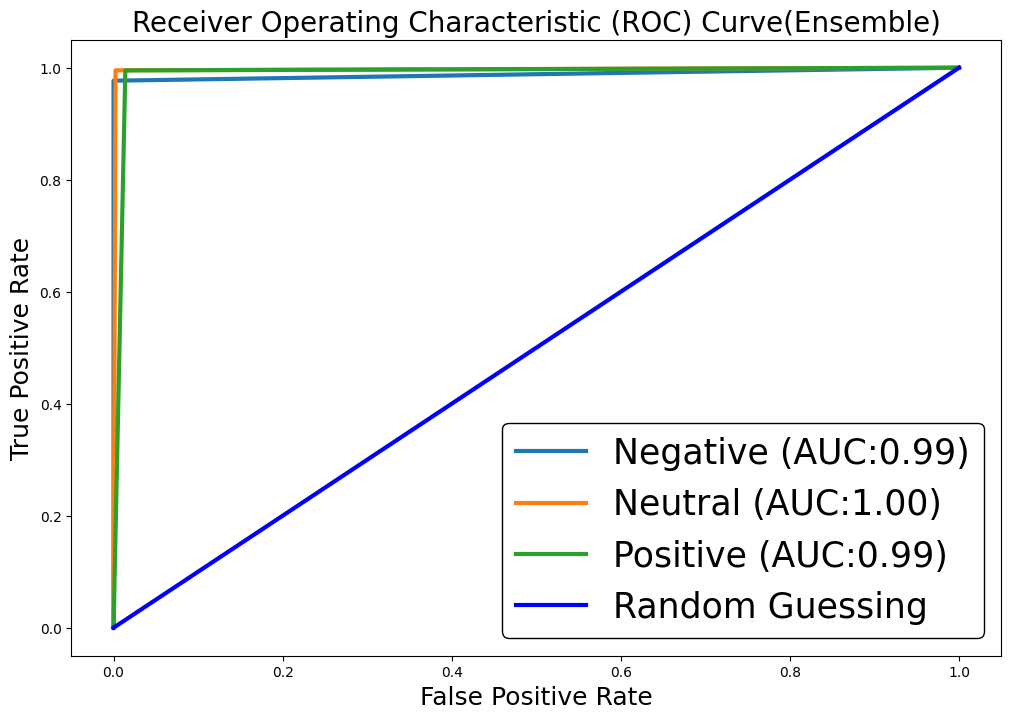

In [155]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target= ['Negative','Neutral','Positive']

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)), lw=3)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing', lw=3)
    return roc_auc_score(y_test, y_pred, average=average)

# Compute ROC AUC score and plot ROC curve
print('ROC AUC score:', multiclass_roc_auc_score(y_test_ensemble_s, y_ensemble_s))

c_ax.legend(fontsize=25, frameon=True, facecolor='white', edgecolor='black', framealpha=1)
c_ax.set_xlabel('False Positive Rate', fontsize=18)
c_ax.set_ylabel('True Positive Rate', fontsize=18)
c_ax.set_title('Receiver Operating Characteristic (ROC) Curve(Ensemble)', fontsize=20)

# Save plot as PNG file and show on screen
plt.savefig('roc_curve_ensemble_st.png', dpi=300, bbox_inches='tight')
plt.show()

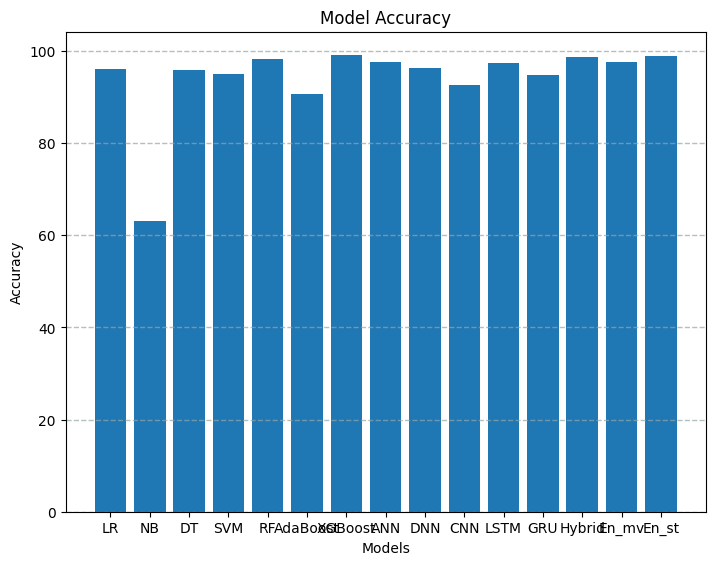

In [156]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
Model = ['LR', 'NB','DT','SVM','RF','AdaBoost','XGBoost','ANN','DNN','CNN','LSTM','GRU','Hybrid','En_mv','En_st']
Accuracy = [acc_lr*100, acc_nb*100, acc_dt*100, acc_svm*100, acc_rf*100, acc_ab*100, acc_xgb*100,acc_ann*100, dnn_acc*100,cnn_acc*100,lstm_acc*100,gru_acc*100,hybrid_acc*100,ensemble_acc*100,ensemble_acc_st*100]
ax.bar(Model,Accuracy)
plt.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.7)
plt.show()

In [157]:
print("Logistic Regression :",acc_lr*100)
print("Naive Bayes :",acc_nb*100)
print("Decision Tree :",acc_dt*100)
print("Support Vector Machine(SVM) :",acc_svm*100)
print("Random Forest :",acc_rf*100)
print("Adaptive Boosting(AdaBoost) :",acc_ab*100)
print("Extreme Gradient Boosting(XGBoost) :",acc_xgb*100)
print("Artificial Neural Networks(ANN) :",acc_ann*100)
print("Deep Neural Networks(DNN) :",dnn_acc*100)
print("Convolutional Neural Network (CNN) :",cnn_acc*100)
print("Long Short-term Memory Networks(LSTM) :",lstm_acc * 100)
print("Gated Recurrent Unit(GRU) :",gru_acc * 100)
print("Hybrid Model (CNN and LSTM Sequential) :",hybrid_accuracy * 100)
print("Ensemble Model using Voting (CNN, LSTM and Hybrid ) :",ensemble_acc * 100)
print("Ensemble Model using Stacking (CNN, LSTM and Hybrid ) :",ensemble_acc_st * 100)

Logistic Regression : 96.09375
Naive Bayes : 63.125
Decision Tree : 95.78125
Support Vector Machine(SVM) : 95.0
Random Forest : 98.28125
Adaptive Boosting(AdaBoost) : 90.625
Extreme Gradient Boosting(XGBoost) : 99.21875
Artificial Neural Networks(ANN) : 97.65625
Deep Neural Networks(DNN) : 96.24999761581421
Convolutional Neural Network (CNN) : 92.65625
Long Short-term Memory Networks(LSTM) : 97.34375
Gated Recurrent Unit(GRU) : 94.84375
Hybrid Model (CNN and LSTM Sequential) : 98.75
Ensemble Model using Voting (CNN, LSTM and Hybrid ) : 97.5
Ensemble Model using Stacking (CNN, LSTM and Hybrid ) : 98.90625
